In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from alpha_vantage.timeseries import TimeSeries 
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from datetime import datetime,timedelta
from dateutil.relativedelta import relativedelta
import pandas_market_calendars as mcal
import os
import yaml

os.chdir("../scripts")
import preprocess, train, inference, interpret

### Note that only 5% of the data is used for validation as we are concerned with short term predictions

In [2]:
config = {
    "alpha_vantage": {
        "key": "2JMCN347HZ3BU9RC", 
        "symbol": "SPY",
        "outputsize": "full",
        "key_adjusted_close": "5. adjusted close",
    },
    "data": {
        "window_size": 20,
        "train_split_size": 0.95,
    }, 
    "plots": {
        "xticks_interval": 90, # show a date every 90 days
        "color_actual": "#001f3f",
        "color_train": "#3D9970",
        "color_val": "#0074D9",
        "color_pred_train": "#3D9970",
        "color_pred_val": "#0074D9",
        "color_pred_test": "#FF4136",
    },
    "model": {
        "input_size": 1, # since for now we are only using close price
        "num_lstm_layers": 2,
        "lstm_size": 32,
        "dropout": 0.2,
    },
    "training": {
        "device": "cpu",
        "batch_size": 64,
        "num_epoch": 100,
        "learning_rate": 0.01,
        "scheduler_step_size": 40,
    }
}

In [3]:
with open("../model/params.yaml", "r") as params_file:
    params = yaml.safe_load(params_file)

data_dir = params['data_dir']
file_name = "SPY.csv"
data = preprocess.load_data(file_name)
data.columns = data.columns.str.capitalize()
data.tail()

,Date,Open,Close,Low,High,Volume
5882,2023-03-20,390.800,393.74,390.07,394.17,93055783.0
5883,2023-03-21,397.240,398.91,395.58,399.41,91524248.0
5884,2023-03-22,398.730,392.11,392.07,402.49,111746583.0
5885,2023-03-23,395.090,393.17,390.35,399.29,119351319.0
5886,2023-03-24,391.841,395.75,389.40,395.84,107770124.0


In [4]:
# amount of simulations and early stop amount

n = 100
stop = 10

### Univariate model

In [5]:
# get data for univariate time series model 

num_data_points = len(data.index)
date_data = data['Date'].to_numpy()
display_date_range = "from " + date_data[0] + " to " + date_data[num_data_points-1]
close_price_data = data['Close'].to_numpy()
close_price_data

array([ 88.21718508,  87.58674188,  88.17651326, ..., 392.11      ,
       393.17      , 395.75      ])

In [6]:
# necessary classes for univariate model

class Normalization():
    def __init__(self):
        self.mu = None
        self.sd = None

    def fit_transform(self, x):
        self.mu = np.mean(x, axis=(0), keepdims=True)
        self.sd = np.std(x, axis=(0), keepdims=True)
        normalized_x = (x - self.mu)/self.sd
        return normalized_x

    def inverse_transform(self, x):
        return (x*self.sd) + self.mu
    
def prepare_data_x(x, window_size):
    # perform windowing
    n_row = x.shape[0] - window_size + 1
    output = np.lib.stride_tricks.as_strided(x, shape=(n_row, window_size), strides=(x.strides[0], x.strides[0]))
    return output[:-1], output[-1]


def prepare_data_y(x, window_size):
    # use the next day as label
    output = x[window_size:]
    return output

class TimeSeriesDataset(Dataset):
    def __init__(self, x, y):
        x = np.expand_dims(x, 2) # right now we have only 1 feature, so we need to convert `x` into [batch, sequence, features]
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])
    
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=32, num_layers=2, output_size=1, dropout=0.2):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.linear_1 = nn.Linear(input_size, hidden_layer_size)
        self.relu = nn.ReLU()
        self.lstm = nn.LSTM(hidden_layer_size, hidden_size=self.hidden_layer_size, num_layers=num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear_2 = nn.Linear(num_layers*hidden_layer_size, output_size)
        
        self.init_weights()

    def init_weights(self):
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                 nn.init.constant_(param, 0.0)
            elif 'weight_ih' in name:
                 nn.init.kaiming_normal_(param)
            elif 'weight_hh' in name:
                 nn.init.orthogonal_(param)

    def forward(self, x):
        batchsize = x.shape[0]

        # layer 1
        x = self.linear_1(x)
        x = self.relu(x)
        
        # LSTM layer
        lstm_out, (h_n, c_n) = self.lstm(x)

        # reshape output from hidden cell into [batch, features] for `linear_2`
        x = h_n.permute(1, 0, 2).reshape(batchsize, -1) 
        
        # layer 2
        x = self.dropout(x)
        predictions = self.linear_2(x)
        return predictions[:,-1]
    
def run_epoch(dataloader, is_training=False):
    epoch_loss = 0

    if is_training:
        model.train()
    else:
        model.eval()

    for idx, (x, y) in enumerate(dataloader):
        if is_training:
            optimizer.zero_grad()

        batchsize = x.shape[0]

        x = x.to(config["training"]["device"])
        y = y.to(config["training"]["device"])

        out = model(x)
        loss = criterion(out.contiguous(), y.contiguous())

        if is_training:
            loss.backward()
            optimizer.step()

        epoch_loss += (loss.detach().item() / batchsize)

    lr = scheduler.get_last_lr()[0]

    return epoch_loss, lr


In [7]:
# prerequisite data manipulation

scaler = Normalization()
normalized_close_price_data = scaler.fit_transform(close_price_data)
normalized_close_price_data

data_x, data_x_unseen = prepare_data_x(normalized_close_price_data, window_size=config["data"]["window_size"])
data_y = prepare_data_y(normalized_close_price_data, window_size=config["data"]["window_size"])

split_index = int(data_y.shape[0]*config["data"]["train_split_size"])
data_x_train = data_x[:split_index]
data_x_val = data_x[split_index:]
data_y_train = data_y[:split_index]
data_y_val = data_y[split_index:]

train_dataset = TimeSeriesDataset(data_x_train, data_y_train)
val_dataset = TimeSeriesDataset(data_x_val, data_y_val)

print("Train data shape", train_dataset.x.shape, train_dataset.y.shape)
print("Validation data shape", val_dataset.x.shape, val_dataset.y.shape)

train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=True)

Train data shape (5573, 20, 1) (5573,)
Validation data shape (294, 20, 1) (294,)


In [8]:
# 100 Epochs

n_epochs = 100
uni_absolute1 = []
uni_root1 = []

for i in range(n):
    train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=True)

    model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
    model = model.to(config["training"]["device"])

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

    for epoch in range(n_epochs):
        loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
        loss_val, lr_val = run_epoch(val_dataloader)
        scheduler.step()

        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
                  .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))
        
    train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=False)

    model.eval()
    
    predicted_train = np.array([])

    for idx, (x, y) in enumerate(train_dataloader):
        x = x.to(config["training"]["device"])
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_train = np.concatenate((predicted_train, out))

    predicted_val = np.array([])

    for idx, (x, y) in enumerate(val_dataloader):
        x = x.to(config["training"]["device"])
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_val = np.concatenate((predicted_val, out))

    data_y_train_pred = np.zeros(num_data_points)
    data_y_val_pred = np.zeros(num_data_points)

    data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    mae = mean_absolute_error(close_price_data, data_y_train_pred + data_y_val_pred)
    print("Mean absolute error: ", mae)

    rmse = np.sqrt(mean_squared_error(close_price_data, data_y_train_pred+data_y_val_pred))
    print("Root mean squared error: ", rmse)
    
    uni_absolute1.append(mae)
    uni_root1.append(rmse)



Epoch[1/100] | loss train:0.079000, test:0.003074 | lr:0.010000
Epoch[2/100] | loss train:0.015098, test:0.002027 | lr:0.010000
Epoch[3/100] | loss train:0.011957, test:0.000332 | lr:0.010000
Epoch[4/100] | loss train:0.013097, test:0.000290 | lr:0.010000
Epoch[5/100] | loss train:0.009396, test:0.005753 | lr:0.010000
Epoch[6/100] | loss train:0.010186, test:0.000375 | lr:0.010000
Epoch[7/100] | loss train:0.008221, test:0.001553 | lr:0.010000
Epoch[8/100] | loss train:0.011663, test:0.007646 | lr:0.010000
Epoch[9/100] | loss train:0.008623, test:0.001055 | lr:0.010000
Epoch[10/100] | loss train:0.007788, test:0.002245 | lr:0.010000
Epoch[11/100] | loss train:0.009263, test:0.000462 | lr:0.010000
Epoch[12/100] | loss train:0.007645, test:0.002081 | lr:0.010000
Epoch[13/100] | loss train:0.009320, test:0.003101 | lr:0.010000
Epoch[14/100] | loss train:0.009699, test:0.001230 | lr:0.010000
Epoch[15/100] | loss train:0.008617, test:0.000824 | lr:0.010000
Epoch[16/100] | loss train:0.00859

Epoch[26/100] | loss train:0.008804, test:0.000584 | lr:0.010000
Epoch[27/100] | loss train:0.007563, test:0.000956 | lr:0.010000
Epoch[28/100] | loss train:0.008424, test:0.000794 | lr:0.010000
Epoch[29/100] | loss train:0.006308, test:0.000768 | lr:0.010000
Epoch[30/100] | loss train:0.007133, test:0.003354 | lr:0.010000
Epoch[31/100] | loss train:0.007793, test:0.002024 | lr:0.010000
Epoch[32/100] | loss train:0.009376, test:0.000759 | lr:0.010000
Epoch[33/100] | loss train:0.008253, test:0.003099 | lr:0.010000
Epoch[34/100] | loss train:0.007378, test:0.000363 | lr:0.010000
Epoch[35/100] | loss train:0.007376, test:0.000510 | lr:0.010000
Epoch[36/100] | loss train:0.008375, test:0.000741 | lr:0.010000
Epoch[37/100] | loss train:0.007419, test:0.000312 | lr:0.010000
Epoch[38/100] | loss train:0.006367, test:0.004608 | lr:0.010000
Epoch[39/100] | loss train:0.007634, test:0.000940 | lr:0.010000
Epoch[40/100] | loss train:0.006840, test:0.002296 | lr:0.010000
Epoch[41/100] | loss trai

Epoch[51/100] | loss train:0.005158, test:0.000333 | lr:0.001000
Epoch[52/100] | loss train:0.005125, test:0.000505 | lr:0.001000
Epoch[53/100] | loss train:0.004647, test:0.000489 | lr:0.001000
Epoch[54/100] | loss train:0.005183, test:0.000295 | lr:0.001000
Epoch[55/100] | loss train:0.004854, test:0.000403 | lr:0.001000
Epoch[56/100] | loss train:0.005178, test:0.000411 | lr:0.001000
Epoch[57/100] | loss train:0.004831, test:0.000306 | lr:0.001000
Epoch[58/100] | loss train:0.005706, test:0.000395 | lr:0.001000
Epoch[59/100] | loss train:0.005475, test:0.000287 | lr:0.001000
Epoch[60/100] | loss train:0.004822, test:0.000358 | lr:0.001000
Epoch[61/100] | loss train:0.005395, test:0.000326 | lr:0.001000
Epoch[62/100] | loss train:0.005533, test:0.000389 | lr:0.001000
Epoch[63/100] | loss train:0.017045, test:0.000326 | lr:0.001000
Epoch[64/100] | loss train:0.004581, test:0.000300 | lr:0.001000
Epoch[65/100] | loss train:0.005330, test:0.000618 | lr:0.001000
Epoch[66/100] | loss trai

Epoch[76/100] | loss train:0.005213, test:0.000339 | lr:0.001000
Epoch[77/100] | loss train:0.004978, test:0.000574 | lr:0.001000
Epoch[78/100] | loss train:0.005081, test:0.000358 | lr:0.001000
Epoch[79/100] | loss train:0.005236, test:0.000326 | lr:0.001000
Epoch[80/100] | loss train:0.005358, test:0.000358 | lr:0.001000
Epoch[81/100] | loss train:0.005420, test:0.000388 | lr:0.000100
Epoch[82/100] | loss train:0.005140, test:0.000366 | lr:0.000100
Epoch[83/100] | loss train:0.004893, test:0.000364 | lr:0.000100
Epoch[84/100] | loss train:0.004799, test:0.000331 | lr:0.000100
Epoch[85/100] | loss train:0.004893, test:0.000365 | lr:0.000100
Epoch[86/100] | loss train:0.004938, test:0.000345 | lr:0.000100
Epoch[87/100] | loss train:0.004738, test:0.000358 | lr:0.000100
Epoch[88/100] | loss train:0.004654, test:0.000348 | lr:0.000100
Epoch[89/100] | loss train:0.005562, test:0.000366 | lr:0.000100
Epoch[90/100] | loss train:0.006082, test:0.000324 | lr:0.000100
Epoch[91/100] | loss trai

Mean absolute error:  1.731096765328927
Root mean squared error:  5.808278556974992
Epoch[1/100] | loss train:0.044094, test:0.000659 | lr:0.010000
Epoch[2/100] | loss train:0.009674, test:0.000367 | lr:0.010000
Epoch[3/100] | loss train:0.013513, test:0.007223 | lr:0.010000
Epoch[4/100] | loss train:0.009263, test:0.001122 | lr:0.010000
Epoch[5/100] | loss train:0.008372, test:0.003767 | lr:0.010000
Epoch[6/100] | loss train:0.009149, test:0.001460 | lr:0.010000
Epoch[7/100] | loss train:0.007396, test:0.000321 | lr:0.010000
Epoch[8/100] | loss train:0.009535, test:0.001094 | lr:0.010000
Epoch[9/100] | loss train:0.007971, test:0.001366 | lr:0.010000
Epoch[10/100] | loss train:0.007014, test:0.005660 | lr:0.010000
Epoch[11/100] | loss train:0.011275, test:0.000586 | lr:0.010000
Epoch[12/100] | loss train:0.007832, test:0.000457 | lr:0.010000
Epoch[13/100] | loss train:0.007746, test:0.002041 | lr:0.010000
Epoch[14/100] | loss train:0.008698, test:0.003216 | lr:0.010000
Epoch[15/100] |

Epoch[25/100] | loss train:0.007963, test:0.001257 | lr:0.010000
Epoch[26/100] | loss train:0.006638, test:0.001644 | lr:0.010000
Epoch[27/100] | loss train:0.025249, test:0.002255 | lr:0.010000
Epoch[28/100] | loss train:0.008637, test:0.000556 | lr:0.010000
Epoch[29/100] | loss train:0.006529, test:0.002495 | lr:0.010000
Epoch[30/100] | loss train:0.011548, test:0.001707 | lr:0.010000
Epoch[31/100] | loss train:0.009294, test:0.000417 | lr:0.010000
Epoch[32/100] | loss train:0.006534, test:0.000532 | lr:0.010000
Epoch[33/100] | loss train:0.007043, test:0.002375 | lr:0.010000
Epoch[34/100] | loss train:0.006654, test:0.000679 | lr:0.010000
Epoch[35/100] | loss train:0.007366, test:0.000403 | lr:0.010000
Epoch[36/100] | loss train:0.007168, test:0.001473 | lr:0.010000
Epoch[37/100] | loss train:0.007225, test:0.003414 | lr:0.010000
Epoch[38/100] | loss train:0.006487, test:0.000862 | lr:0.010000
Epoch[39/100] | loss train:0.007068, test:0.001010 | lr:0.010000
Epoch[40/100] | loss trai

Epoch[50/100] | loss train:0.006192, test:0.000382 | lr:0.001000
Epoch[51/100] | loss train:0.004756, test:0.000425 | lr:0.001000
Epoch[52/100] | loss train:0.004703, test:0.000413 | lr:0.001000
Epoch[53/100] | loss train:0.004792, test:0.000340 | lr:0.001000
Epoch[54/100] | loss train:0.005348, test:0.000519 | lr:0.001000
Epoch[55/100] | loss train:0.005343, test:0.000511 | lr:0.001000
Epoch[56/100] | loss train:0.004881, test:0.000454 | lr:0.001000
Epoch[57/100] | loss train:0.005180, test:0.000341 | lr:0.001000
Epoch[58/100] | loss train:0.004622, test:0.000351 | lr:0.001000
Epoch[59/100] | loss train:0.009099, test:0.000347 | lr:0.001000
Epoch[60/100] | loss train:0.005202, test:0.000349 | lr:0.001000
Epoch[61/100] | loss train:0.004520, test:0.000498 | lr:0.001000
Epoch[62/100] | loss train:0.005308, test:0.000351 | lr:0.001000
Epoch[63/100] | loss train:0.005318, test:0.000950 | lr:0.001000
Epoch[64/100] | loss train:0.005803, test:0.000360 | lr:0.001000
Epoch[65/100] | loss trai

Epoch[75/100] | loss train:0.008041, test:0.000375 | lr:0.001000
Epoch[76/100] | loss train:0.006727, test:0.000296 | lr:0.001000
Epoch[77/100] | loss train:0.004928, test:0.000320 | lr:0.001000
Epoch[78/100] | loss train:0.004890, test:0.000288 | lr:0.001000
Epoch[79/100] | loss train:0.005011, test:0.000410 | lr:0.001000
Epoch[80/100] | loss train:0.004881, test:0.000320 | lr:0.001000
Epoch[81/100] | loss train:0.005139, test:0.000301 | lr:0.000100
Epoch[82/100] | loss train:0.005387, test:0.000309 | lr:0.000100
Epoch[83/100] | loss train:0.004868, test:0.000300 | lr:0.000100
Epoch[84/100] | loss train:0.007436, test:0.000304 | lr:0.000100
Epoch[85/100] | loss train:0.005111, test:0.000290 | lr:0.000100
Epoch[86/100] | loss train:0.005362, test:0.000311 | lr:0.000100
Epoch[87/100] | loss train:0.004439, test:0.000311 | lr:0.000100
Epoch[88/100] | loss train:0.004495, test:0.000291 | lr:0.000100
Epoch[89/100] | loss train:0.005247, test:0.000270 | lr:0.000100
Epoch[90/100] | loss trai

Epoch[100/100] | loss train:0.010912, test:0.000332 | lr:0.000100
Mean absolute error:  1.7510201254624465
Root mean squared error:  5.824139977090864
Epoch[1/100] | loss train:0.038913, test:0.003893 | lr:0.010000
Epoch[2/100] | loss train:0.014419, test:0.001161 | lr:0.010000
Epoch[3/100] | loss train:0.011384, test:0.005967 | lr:0.010000
Epoch[4/100] | loss train:0.009956, test:0.001089 | lr:0.010000
Epoch[5/100] | loss train:0.008178, test:0.000398 | lr:0.010000
Epoch[6/100] | loss train:0.007962, test:0.001436 | lr:0.010000
Epoch[7/100] | loss train:0.018099, test:0.004784 | lr:0.010000
Epoch[8/100] | loss train:0.011584, test:0.000636 | lr:0.010000
Epoch[9/100] | loss train:0.008079, test:0.000409 | lr:0.010000
Epoch[10/100] | loss train:0.007515, test:0.000429 | lr:0.010000
Epoch[11/100] | loss train:0.009259, test:0.000478 | lr:0.010000
Epoch[12/100] | loss train:0.006798, test:0.000632 | lr:0.010000
Epoch[13/100] | loss train:0.010785, test:0.010702 | lr:0.010000
Epoch[14/100]

Epoch[24/100] | loss train:0.006945, test:0.000600 | lr:0.010000
Epoch[25/100] | loss train:0.007385, test:0.000747 | lr:0.010000
Epoch[26/100] | loss train:0.006544, test:0.001828 | lr:0.010000
Epoch[27/100] | loss train:0.007054, test:0.000608 | lr:0.010000
Epoch[28/100] | loss train:0.006505, test:0.004115 | lr:0.010000
Epoch[29/100] | loss train:0.007597, test:0.000314 | lr:0.010000
Epoch[30/100] | loss train:0.006553, test:0.000669 | lr:0.010000
Epoch[31/100] | loss train:0.007436, test:0.001377 | lr:0.010000
Epoch[32/100] | loss train:0.006488, test:0.000921 | lr:0.010000
Epoch[33/100] | loss train:0.006740, test:0.000507 | lr:0.010000
Epoch[34/100] | loss train:0.010173, test:0.000359 | lr:0.010000
Epoch[35/100] | loss train:0.006338, test:0.002257 | lr:0.010000
Epoch[36/100] | loss train:0.007006, test:0.000806 | lr:0.010000
Epoch[37/100] | loss train:0.009559, test:0.000480 | lr:0.010000
Epoch[38/100] | loss train:0.006159, test:0.000405 | lr:0.010000
Epoch[39/100] | loss trai

Epoch[49/100] | loss train:0.005634, test:0.000576 | lr:0.001000
Epoch[50/100] | loss train:0.005367, test:0.000352 | lr:0.001000
Epoch[51/100] | loss train:0.005680, test:0.000358 | lr:0.001000
Epoch[52/100] | loss train:0.005466, test:0.000730 | lr:0.001000
Epoch[53/100] | loss train:0.005586, test:0.000481 | lr:0.001000
Epoch[54/100] | loss train:0.005099, test:0.000489 | lr:0.001000
Epoch[55/100] | loss train:0.005058, test:0.000432 | lr:0.001000
Epoch[56/100] | loss train:0.005131, test:0.000633 | lr:0.001000
Epoch[57/100] | loss train:0.007230, test:0.000371 | lr:0.001000
Epoch[58/100] | loss train:0.005184, test:0.000357 | lr:0.001000
Epoch[59/100] | loss train:0.005165, test:0.000685 | lr:0.001000
Epoch[60/100] | loss train:0.005162, test:0.000623 | lr:0.001000
Epoch[61/100] | loss train:0.005848, test:0.000397 | lr:0.001000
Epoch[62/100] | loss train:0.005219, test:0.000388 | lr:0.001000
Epoch[63/100] | loss train:0.005850, test:0.000406 | lr:0.001000
Epoch[64/100] | loss trai

Epoch[74/100] | loss train:0.008060, test:0.000314 | lr:0.001000
Epoch[75/100] | loss train:0.006120, test:0.000302 | lr:0.001000
Epoch[76/100] | loss train:0.004763, test:0.000318 | lr:0.001000
Epoch[77/100] | loss train:0.005294, test:0.000485 | lr:0.001000
Epoch[78/100] | loss train:0.004902, test:0.000437 | lr:0.001000
Epoch[79/100] | loss train:0.005093, test:0.000383 | lr:0.001000
Epoch[80/100] | loss train:0.005358, test:0.000366 | lr:0.001000
Epoch[81/100] | loss train:0.005309, test:0.000305 | lr:0.000100
Epoch[82/100] | loss train:0.004971, test:0.000319 | lr:0.000100
Epoch[83/100] | loss train:0.005199, test:0.000372 | lr:0.000100
Epoch[84/100] | loss train:0.005548, test:0.000347 | lr:0.000100
Epoch[85/100] | loss train:0.004992, test:0.000285 | lr:0.000100
Epoch[86/100] | loss train:0.005024, test:0.000287 | lr:0.000100
Epoch[87/100] | loss train:0.005594, test:0.000313 | lr:0.000100
Epoch[88/100] | loss train:0.006239, test:0.000309 | lr:0.000100
Epoch[89/100] | loss trai

Epoch[99/100] | loss train:0.004455, test:0.000275 | lr:0.000100
Epoch[100/100] | loss train:0.004791, test:0.000298 | lr:0.000100
Mean absolute error:  1.650408658156605
Root mean squared error:  5.7628944670178
Epoch[1/100] | loss train:0.049659, test:0.001219 | lr:0.010000
Epoch[2/100] | loss train:0.012298, test:0.004004 | lr:0.010000
Epoch[3/100] | loss train:0.011636, test:0.000517 | lr:0.010000
Epoch[4/100] | loss train:0.010842, test:0.003584 | lr:0.010000
Epoch[5/100] | loss train:0.011391, test:0.002777 | lr:0.010000
Epoch[6/100] | loss train:0.008594, test:0.000325 | lr:0.010000
Epoch[7/100] | loss train:0.007952, test:0.000832 | lr:0.010000
Epoch[8/100] | loss train:0.018174, test:0.000802 | lr:0.010000
Epoch[9/100] | loss train:0.009095, test:0.000404 | lr:0.010000
Epoch[10/100] | loss train:0.013629, test:0.000625 | lr:0.010000
Epoch[11/100] | loss train:0.008118, test:0.000438 | lr:0.010000
Epoch[12/100] | loss train:0.008247, test:0.000444 | lr:0.010000
Epoch[13/100] | 

Epoch[23/100] | loss train:0.008291, test:0.000677 | lr:0.010000
Epoch[24/100] | loss train:0.007476, test:0.000608 | lr:0.010000
Epoch[25/100] | loss train:0.008451, test:0.000537 | lr:0.010000
Epoch[26/100] | loss train:0.007697, test:0.001085 | lr:0.010000
Epoch[27/100] | loss train:0.008487, test:0.000457 | lr:0.010000
Epoch[28/100] | loss train:0.007062, test:0.001463 | lr:0.010000
Epoch[29/100] | loss train:0.007947, test:0.000754 | lr:0.010000
Epoch[30/100] | loss train:0.006973, test:0.000530 | lr:0.010000
Epoch[31/100] | loss train:0.007792, test:0.000373 | lr:0.010000
Epoch[32/100] | loss train:0.007457, test:0.001680 | lr:0.010000
Epoch[33/100] | loss train:0.009182, test:0.002543 | lr:0.010000
Epoch[34/100] | loss train:0.007604, test:0.002669 | lr:0.010000
Epoch[35/100] | loss train:0.008997, test:0.000630 | lr:0.010000
Epoch[36/100] | loss train:0.007480, test:0.000620 | lr:0.010000
Epoch[37/100] | loss train:0.008008, test:0.000394 | lr:0.010000
Epoch[38/100] | loss trai

Epoch[48/100] | loss train:0.008430, test:0.000478 | lr:0.001000
Epoch[49/100] | loss train:0.005305, test:0.000293 | lr:0.001000
Epoch[50/100] | loss train:0.006391, test:0.000325 | lr:0.001000
Epoch[51/100] | loss train:0.005372, test:0.000326 | lr:0.001000
Epoch[52/100] | loss train:0.005995, test:0.000432 | lr:0.001000
Epoch[53/100] | loss train:0.005478, test:0.000307 | lr:0.001000
Epoch[54/100] | loss train:0.005229, test:0.000407 | lr:0.001000
Epoch[55/100] | loss train:0.005180, test:0.000325 | lr:0.001000
Epoch[56/100] | loss train:0.006371, test:0.000301 | lr:0.001000
Epoch[57/100] | loss train:0.007335, test:0.000363 | lr:0.001000
Epoch[58/100] | loss train:0.005427, test:0.000346 | lr:0.001000
Epoch[59/100] | loss train:0.005338, test:0.000283 | lr:0.001000
Epoch[60/100] | loss train:0.005365, test:0.000298 | lr:0.001000
Epoch[61/100] | loss train:0.005425, test:0.000343 | lr:0.001000
Epoch[62/100] | loss train:0.005430, test:0.000378 | lr:0.001000
Epoch[63/100] | loss trai

Epoch[73/100] | loss train:0.006045, test:0.000982 | lr:0.001000
Epoch[74/100] | loss train:0.005945, test:0.000374 | lr:0.001000
Epoch[75/100] | loss train:0.007565, test:0.000365 | lr:0.001000
Epoch[76/100] | loss train:0.005973, test:0.000432 | lr:0.001000
Epoch[77/100] | loss train:0.006108, test:0.000375 | lr:0.001000
Epoch[78/100] | loss train:0.005168, test:0.000380 | lr:0.001000
Epoch[79/100] | loss train:0.007144, test:0.000355 | lr:0.001000
Epoch[80/100] | loss train:0.006255, test:0.000343 | lr:0.001000
Epoch[81/100] | loss train:0.005397, test:0.000343 | lr:0.000100
Epoch[82/100] | loss train:0.005373, test:0.000367 | lr:0.000100
Epoch[83/100] | loss train:0.005700, test:0.000346 | lr:0.000100
Epoch[84/100] | loss train:0.005801, test:0.000373 | lr:0.000100
Epoch[85/100] | loss train:0.005536, test:0.000342 | lr:0.000100
Epoch[86/100] | loss train:0.005561, test:0.000370 | lr:0.000100
Epoch[87/100] | loss train:0.005960, test:0.000345 | lr:0.000100
Epoch[88/100] | loss trai

Epoch[98/100] | loss train:0.004913, test:0.000341 | lr:0.000100
Epoch[99/100] | loss train:0.005098, test:0.000290 | lr:0.000100
Epoch[100/100] | loss train:0.005469, test:0.000372 | lr:0.000100
Mean absolute error:  1.8113014155853298
Root mean squared error:  5.877807638952578
Epoch[1/100] | loss train:0.052776, test:0.001405 | lr:0.010000
Epoch[2/100] | loss train:0.011646, test:0.002237 | lr:0.010000
Epoch[3/100] | loss train:0.009217, test:0.008009 | lr:0.010000
Epoch[4/100] | loss train:0.009431, test:0.001391 | lr:0.010000
Epoch[5/100] | loss train:0.008100, test:0.003862 | lr:0.010000
Epoch[6/100] | loss train:0.009462, test:0.001428 | lr:0.010000
Epoch[7/100] | loss train:0.007749, test:0.002314 | lr:0.010000
Epoch[8/100] | loss train:0.008368, test:0.005028 | lr:0.010000
Epoch[9/100] | loss train:0.008710, test:0.000474 | lr:0.010000
Epoch[10/100] | loss train:0.008414, test:0.001658 | lr:0.010000
Epoch[11/100] | loss train:0.010114, test:0.004345 | lr:0.010000
Epoch[12/100]

Epoch[22/100] | loss train:0.010303, test:0.007436 | lr:0.010000
Epoch[23/100] | loss train:0.008720, test:0.001144 | lr:0.010000
Epoch[24/100] | loss train:0.009201, test:0.000451 | lr:0.010000
Epoch[25/100] | loss train:0.008869, test:0.000620 | lr:0.010000
Epoch[26/100] | loss train:0.007472, test:0.001492 | lr:0.010000
Epoch[27/100] | loss train:0.008333, test:0.000435 | lr:0.010000
Epoch[28/100] | loss train:0.007578, test:0.000421 | lr:0.010000
Epoch[29/100] | loss train:0.006780, test:0.000429 | lr:0.010000
Epoch[30/100] | loss train:0.007220, test:0.001524 | lr:0.010000
Epoch[31/100] | loss train:0.007660, test:0.000715 | lr:0.010000
Epoch[32/100] | loss train:0.007313, test:0.000668 | lr:0.010000
Epoch[33/100] | loss train:0.007330, test:0.000378 | lr:0.010000
Epoch[34/100] | loss train:0.008450, test:0.000751 | lr:0.010000
Epoch[35/100] | loss train:0.006480, test:0.000862 | lr:0.010000
Epoch[36/100] | loss train:0.007370, test:0.000650 | lr:0.010000
Epoch[37/100] | loss trai

Epoch[47/100] | loss train:0.006762, test:0.000866 | lr:0.001000
Epoch[48/100] | loss train:0.005311, test:0.000358 | lr:0.001000
Epoch[49/100] | loss train:0.005119, test:0.000311 | lr:0.001000
Epoch[50/100] | loss train:0.006526, test:0.000442 | lr:0.001000
Epoch[51/100] | loss train:0.005315, test:0.000570 | lr:0.001000
Epoch[52/100] | loss train:0.006265, test:0.000647 | lr:0.001000
Epoch[53/100] | loss train:0.006058, test:0.000750 | lr:0.001000
Epoch[54/100] | loss train:0.005375, test:0.000437 | lr:0.001000
Epoch[55/100] | loss train:0.005212, test:0.000391 | lr:0.001000
Epoch[56/100] | loss train:0.006022, test:0.000466 | lr:0.001000
Epoch[57/100] | loss train:0.005341, test:0.000344 | lr:0.001000
Epoch[58/100] | loss train:0.005394, test:0.000410 | lr:0.001000
Epoch[59/100] | loss train:0.006620, test:0.000360 | lr:0.001000
Epoch[60/100] | loss train:0.005248, test:0.000325 | lr:0.001000
Epoch[61/100] | loss train:0.004775, test:0.000414 | lr:0.001000
Epoch[62/100] | loss trai

Epoch[72/100] | loss train:0.005461, test:0.000276 | lr:0.001000
Epoch[73/100] | loss train:0.005592, test:0.000352 | lr:0.001000
Epoch[74/100] | loss train:0.005435, test:0.000416 | lr:0.001000
Epoch[75/100] | loss train:0.005130, test:0.000312 | lr:0.001000
Epoch[76/100] | loss train:0.005051, test:0.000307 | lr:0.001000
Epoch[77/100] | loss train:0.005131, test:0.000492 | lr:0.001000
Epoch[78/100] | loss train:0.004803, test:0.000275 | lr:0.001000
Epoch[79/100] | loss train:0.005199, test:0.000433 | lr:0.001000
Epoch[80/100] | loss train:0.005543, test:0.000381 | lr:0.001000
Epoch[81/100] | loss train:0.009491, test:0.000288 | lr:0.000100
Epoch[82/100] | loss train:0.005079, test:0.000300 | lr:0.000100
Epoch[83/100] | loss train:0.004794, test:0.000291 | lr:0.000100
Epoch[84/100] | loss train:0.005283, test:0.000273 | lr:0.000100
Epoch[85/100] | loss train:0.004954, test:0.000261 | lr:0.000100
Epoch[86/100] | loss train:0.004983, test:0.000292 | lr:0.000100
Epoch[87/100] | loss trai

Epoch[97/100] | loss train:0.005389, test:0.000285 | lr:0.000100
Epoch[98/100] | loss train:0.004918, test:0.000291 | lr:0.000100
Epoch[99/100] | loss train:0.005362, test:0.000331 | lr:0.000100
Epoch[100/100] | loss train:0.004934, test:0.000283 | lr:0.000100
Mean absolute error:  1.7200626767071105
Root mean squared error:  5.7917138241789035
Epoch[1/100] | loss train:0.049379, test:0.000601 | lr:0.010000
Epoch[2/100] | loss train:0.013060, test:0.000348 | lr:0.010000
Epoch[3/100] | loss train:0.010625, test:0.001311 | lr:0.010000
Epoch[4/100] | loss train:0.009999, test:0.000915 | lr:0.010000
Epoch[5/100] | loss train:0.009815, test:0.000830 | lr:0.010000
Epoch[6/100] | loss train:0.009971, test:0.003765 | lr:0.010000
Epoch[7/100] | loss train:0.007406, test:0.001707 | lr:0.010000
Epoch[8/100] | loss train:0.009082, test:0.000349 | lr:0.010000
Epoch[9/100] | loss train:0.007707, test:0.000961 | lr:0.010000
Epoch[10/100] | loss train:0.007973, test:0.000721 | lr:0.010000
Epoch[11/100

Epoch[21/100] | loss train:0.007261, test:0.000775 | lr:0.010000
Epoch[22/100] | loss train:0.008530, test:0.000489 | lr:0.010000
Epoch[23/100] | loss train:0.006414, test:0.001720 | lr:0.010000
Epoch[24/100] | loss train:0.010266, test:0.000356 | lr:0.010000
Epoch[25/100] | loss train:0.008312, test:0.003344 | lr:0.010000
Epoch[26/100] | loss train:0.007710, test:0.000893 | lr:0.010000
Epoch[27/100] | loss train:0.007929, test:0.001808 | lr:0.010000
Epoch[28/100] | loss train:0.007602, test:0.001742 | lr:0.010000
Epoch[29/100] | loss train:0.007339, test:0.000288 | lr:0.010000
Epoch[30/100] | loss train:0.006342, test:0.000599 | lr:0.010000
Epoch[31/100] | loss train:0.007955, test:0.001206 | lr:0.010000
Epoch[32/100] | loss train:0.006415, test:0.000539 | lr:0.010000
Epoch[33/100] | loss train:0.007578, test:0.000482 | lr:0.010000
Epoch[34/100] | loss train:0.013886, test:0.002121 | lr:0.010000
Epoch[35/100] | loss train:0.006902, test:0.000537 | lr:0.010000
Epoch[36/100] | loss trai

Epoch[46/100] | loss train:0.005344, test:0.000412 | lr:0.001000
Epoch[47/100] | loss train:0.005000, test:0.000479 | lr:0.001000
Epoch[48/100] | loss train:0.004997, test:0.000372 | lr:0.001000
Epoch[49/100] | loss train:0.005204, test:0.000368 | lr:0.001000
Epoch[50/100] | loss train:0.005270, test:0.000381 | lr:0.001000
Epoch[51/100] | loss train:0.004862, test:0.000440 | lr:0.001000
Epoch[52/100] | loss train:0.005370, test:0.000432 | lr:0.001000
Epoch[53/100] | loss train:0.006261, test:0.000394 | lr:0.001000
Epoch[54/100] | loss train:0.005202, test:0.000478 | lr:0.001000
Epoch[55/100] | loss train:0.005636, test:0.000372 | lr:0.001000
Epoch[56/100] | loss train:0.006822, test:0.000395 | lr:0.001000
Epoch[57/100] | loss train:0.004835, test:0.000364 | lr:0.001000
Epoch[58/100] | loss train:0.004854, test:0.000378 | lr:0.001000
Epoch[59/100] | loss train:0.005451, test:0.000395 | lr:0.001000
Epoch[60/100] | loss train:0.005256, test:0.000338 | lr:0.001000
Epoch[61/100] | loss trai

Epoch[71/100] | loss train:0.005555, test:0.000473 | lr:0.001000
Epoch[72/100] | loss train:0.005902, test:0.000420 | lr:0.001000
Epoch[73/100] | loss train:0.005276, test:0.000542 | lr:0.001000
Epoch[74/100] | loss train:0.005385, test:0.000324 | lr:0.001000
Epoch[75/100] | loss train:0.006730, test:0.000348 | lr:0.001000
Epoch[76/100] | loss train:0.006027, test:0.000330 | lr:0.001000
Epoch[77/100] | loss train:0.008099, test:0.000396 | lr:0.001000
Epoch[78/100] | loss train:0.007423, test:0.000488 | lr:0.001000
Epoch[79/100] | loss train:0.006254, test:0.000410 | lr:0.001000
Epoch[80/100] | loss train:0.006316, test:0.000552 | lr:0.001000
Epoch[81/100] | loss train:0.005015, test:0.000308 | lr:0.000100
Epoch[82/100] | loss train:0.005094, test:0.000318 | lr:0.000100
Epoch[83/100] | loss train:0.005175, test:0.000304 | lr:0.000100
Epoch[84/100] | loss train:0.005528, test:0.000341 | lr:0.000100
Epoch[85/100] | loss train:0.005288, test:0.000297 | lr:0.000100
Epoch[86/100] | loss trai

Epoch[96/100] | loss train:0.005359, test:0.000326 | lr:0.000100
Epoch[97/100] | loss train:0.005141, test:0.000326 | lr:0.000100
Epoch[98/100] | loss train:0.004520, test:0.000337 | lr:0.000100
Epoch[99/100] | loss train:0.004578, test:0.000310 | lr:0.000100
Epoch[100/100] | loss train:0.004982, test:0.000317 | lr:0.000100
Mean absolute error:  1.708259413303387
Root mean squared error:  5.803713120632178
Epoch[1/100] | loss train:0.049183, test:0.001199 | lr:0.010000
Epoch[2/100] | loss train:0.010956, test:0.000467 | lr:0.010000
Epoch[3/100] | loss train:0.010373, test:0.004731 | lr:0.010000
Epoch[4/100] | loss train:0.009631, test:0.005146 | lr:0.010000
Epoch[5/100] | loss train:0.010064, test:0.005607 | lr:0.010000
Epoch[6/100] | loss train:0.008362, test:0.001979 | lr:0.010000
Epoch[7/100] | loss train:0.009340, test:0.002078 | lr:0.010000
Epoch[8/100] | loss train:0.008974, test:0.000710 | lr:0.010000
Epoch[9/100] | loss train:0.013693, test:0.001732 | lr:0.010000
Epoch[10/100] 

Epoch[20/100] | loss train:0.007016, test:0.001015 | lr:0.010000
Epoch[21/100] | loss train:0.007728, test:0.003178 | lr:0.010000
Epoch[22/100] | loss train:0.007084, test:0.002084 | lr:0.010000
Epoch[23/100] | loss train:0.007779, test:0.001293 | lr:0.010000
Epoch[24/100] | loss train:0.012883, test:0.001542 | lr:0.010000
Epoch[25/100] | loss train:0.008543, test:0.000666 | lr:0.010000
Epoch[26/100] | loss train:0.010439, test:0.003181 | lr:0.010000
Epoch[27/100] | loss train:0.009795, test:0.000937 | lr:0.010000
Epoch[28/100] | loss train:0.007659, test:0.002157 | lr:0.010000
Epoch[29/100] | loss train:0.008283, test:0.000413 | lr:0.010000
Epoch[30/100] | loss train:0.007242, test:0.001533 | lr:0.010000
Epoch[31/100] | loss train:0.007208, test:0.000643 | lr:0.010000
Epoch[32/100] | loss train:0.007296, test:0.000634 | lr:0.010000
Epoch[33/100] | loss train:0.007458, test:0.000561 | lr:0.010000
Epoch[34/100] | loss train:0.007543, test:0.000868 | lr:0.010000
Epoch[35/100] | loss trai

Epoch[45/100] | loss train:0.005021, test:0.000444 | lr:0.001000
Epoch[46/100] | loss train:0.006153, test:0.000429 | lr:0.001000
Epoch[47/100] | loss train:0.004780, test:0.000358 | lr:0.001000
Epoch[48/100] | loss train:0.004776, test:0.000427 | lr:0.001000
Epoch[49/100] | loss train:0.004748, test:0.000582 | lr:0.001000
Epoch[50/100] | loss train:0.005485, test:0.000725 | lr:0.001000
Epoch[51/100] | loss train:0.004850, test:0.000401 | lr:0.001000
Epoch[52/100] | loss train:0.005810, test:0.000414 | lr:0.001000
Epoch[53/100] | loss train:0.005297, test:0.000360 | lr:0.001000
Epoch[54/100] | loss train:0.005071, test:0.000401 | lr:0.001000
Epoch[55/100] | loss train:0.005557, test:0.000358 | lr:0.001000
Epoch[56/100] | loss train:0.005176, test:0.000435 | lr:0.001000
Epoch[57/100] | loss train:0.005417, test:0.000361 | lr:0.001000
Epoch[58/100] | loss train:0.006228, test:0.000407 | lr:0.001000
Epoch[59/100] | loss train:0.005350, test:0.000404 | lr:0.001000
Epoch[60/100] | loss trai

Epoch[70/100] | loss train:0.005678, test:0.000331 | lr:0.001000
Epoch[71/100] | loss train:0.005751, test:0.000374 | lr:0.001000
Epoch[72/100] | loss train:0.005290, test:0.000406 | lr:0.001000
Epoch[73/100] | loss train:0.005514, test:0.000334 | lr:0.001000
Epoch[74/100] | loss train:0.005359, test:0.000368 | lr:0.001000
Epoch[75/100] | loss train:0.010087, test:0.000357 | lr:0.001000
Epoch[76/100] | loss train:0.006046, test:0.000360 | lr:0.001000
Epoch[77/100] | loss train:0.006158, test:0.000329 | lr:0.001000
Epoch[78/100] | loss train:0.005296, test:0.000318 | lr:0.001000
Epoch[79/100] | loss train:0.005381, test:0.000363 | lr:0.001000
Epoch[80/100] | loss train:0.006346, test:0.000347 | lr:0.001000
Epoch[81/100] | loss train:0.005387, test:0.000343 | lr:0.000100
Epoch[82/100] | loss train:0.005508, test:0.000371 | lr:0.000100
Epoch[83/100] | loss train:0.005376, test:0.000352 | lr:0.000100
Epoch[84/100] | loss train:0.006187, test:0.000336 | lr:0.000100
Epoch[85/100] | loss trai

Epoch[95/100] | loss train:0.004955, test:0.000305 | lr:0.000100
Epoch[96/100] | loss train:0.005407, test:0.000292 | lr:0.000100
Epoch[97/100] | loss train:0.011755, test:0.000301 | lr:0.000100
Epoch[98/100] | loss train:0.004946, test:0.000279 | lr:0.000100
Epoch[99/100] | loss train:0.005055, test:0.000285 | lr:0.000100
Epoch[100/100] | loss train:0.004874, test:0.000301 | lr:0.000100
Mean absolute error:  1.7631447805235134
Root mean squared error:  5.814527428714107
Epoch[1/100] | loss train:0.059576, test:0.001400 | lr:0.010000
Epoch[2/100] | loss train:0.009894, test:0.008244 | lr:0.010000
Epoch[3/100] | loss train:0.012460, test:0.000777 | lr:0.010000
Epoch[4/100] | loss train:0.011097, test:0.000315 | lr:0.010000
Epoch[5/100] | loss train:0.007815, test:0.000823 | lr:0.010000
Epoch[6/100] | loss train:0.009918, test:0.000882 | lr:0.010000
Epoch[7/100] | loss train:0.007424, test:0.000378 | lr:0.010000
Epoch[8/100] | loss train:0.008243, test:0.003662 | lr:0.010000
Epoch[9/100]

Epoch[19/100] | loss train:0.007640, test:0.000685 | lr:0.010000
Epoch[20/100] | loss train:0.007771, test:0.000565 | lr:0.010000
Epoch[21/100] | loss train:0.007215, test:0.003316 | lr:0.010000
Epoch[22/100] | loss train:0.007665, test:0.001662 | lr:0.010000
Epoch[23/100] | loss train:0.008006, test:0.000490 | lr:0.010000
Epoch[24/100] | loss train:0.007136, test:0.000674 | lr:0.010000
Epoch[25/100] | loss train:0.006489, test:0.001987 | lr:0.010000
Epoch[26/100] | loss train:0.006236, test:0.000491 | lr:0.010000
Epoch[27/100] | loss train:0.010646, test:0.002642 | lr:0.010000
Epoch[28/100] | loss train:0.010324, test:0.000522 | lr:0.010000
Epoch[29/100] | loss train:0.006722, test:0.001443 | lr:0.010000
Epoch[30/100] | loss train:0.007270, test:0.000618 | lr:0.010000
Epoch[31/100] | loss train:0.008597, test:0.003050 | lr:0.010000
Epoch[32/100] | loss train:0.011185, test:0.001441 | lr:0.010000
Epoch[33/100] | loss train:0.008831, test:0.000602 | lr:0.010000
Epoch[34/100] | loss trai

Epoch[44/100] | loss train:0.006230, test:0.000618 | lr:0.001000
Epoch[45/100] | loss train:0.004905, test:0.000424 | lr:0.001000
Epoch[46/100] | loss train:0.004988, test:0.000636 | lr:0.001000
Epoch[47/100] | loss train:0.006130, test:0.000401 | lr:0.001000
Epoch[48/100] | loss train:0.005412, test:0.000391 | lr:0.001000
Epoch[49/100] | loss train:0.006132, test:0.000426 | lr:0.001000
Epoch[50/100] | loss train:0.004985, test:0.000430 | lr:0.001000
Epoch[51/100] | loss train:0.005229, test:0.000402 | lr:0.001000
Epoch[52/100] | loss train:0.005368, test:0.000507 | lr:0.001000
Epoch[53/100] | loss train:0.005178, test:0.000365 | lr:0.001000
Epoch[54/100] | loss train:0.004946, test:0.000437 | lr:0.001000
Epoch[55/100] | loss train:0.004903, test:0.000380 | lr:0.001000
Epoch[56/100] | loss train:0.005907, test:0.000365 | lr:0.001000
Epoch[57/100] | loss train:0.005664, test:0.000436 | lr:0.001000
Epoch[58/100] | loss train:0.004792, test:0.000362 | lr:0.001000
Epoch[59/100] | loss trai

Epoch[69/100] | loss train:0.005329, test:0.000417 | lr:0.001000
Epoch[70/100] | loss train:0.005570, test:0.000416 | lr:0.001000
Epoch[71/100] | loss train:0.005767, test:0.000399 | lr:0.001000
Epoch[72/100] | loss train:0.005828, test:0.000441 | lr:0.001000
Epoch[73/100] | loss train:0.005035, test:0.000370 | lr:0.001000
Epoch[74/100] | loss train:0.005284, test:0.000542 | lr:0.001000
Epoch[75/100] | loss train:0.006586, test:0.000402 | lr:0.001000
Epoch[76/100] | loss train:0.005960, test:0.000425 | lr:0.001000
Epoch[77/100] | loss train:0.006644, test:0.000395 | lr:0.001000
Epoch[78/100] | loss train:0.010856, test:0.000482 | lr:0.001000
Epoch[79/100] | loss train:0.005327, test:0.000380 | lr:0.001000
Epoch[80/100] | loss train:0.005232, test:0.000981 | lr:0.001000
Epoch[81/100] | loss train:0.008096, test:0.000382 | lr:0.000100
Epoch[82/100] | loss train:0.005852, test:0.000359 | lr:0.000100
Epoch[83/100] | loss train:0.005674, test:0.000418 | lr:0.000100
Epoch[84/100] | loss trai

Epoch[94/100] | loss train:0.005216, test:0.000299 | lr:0.000100
Epoch[95/100] | loss train:0.005469, test:0.000279 | lr:0.000100
Epoch[96/100] | loss train:0.006055, test:0.000282 | lr:0.000100
Epoch[97/100] | loss train:0.005759, test:0.000304 | lr:0.000100
Epoch[98/100] | loss train:0.004997, test:0.000266 | lr:0.000100
Epoch[99/100] | loss train:0.006550, test:0.000293 | lr:0.000100
Epoch[100/100] | loss train:0.005121, test:0.000282 | lr:0.000100
Mean absolute error:  1.7078983237105145
Root mean squared error:  5.801159457666768
Epoch[1/100] | loss train:0.064845, test:0.002707 | lr:0.010000
Epoch[2/100] | loss train:0.016146, test:0.000424 | lr:0.010000
Epoch[3/100] | loss train:0.012166, test:0.000699 | lr:0.010000
Epoch[4/100] | loss train:0.011322, test:0.009210 | lr:0.010000
Epoch[5/100] | loss train:0.010279, test:0.000296 | lr:0.010000
Epoch[6/100] | loss train:0.009756, test:0.000307 | lr:0.010000
Epoch[7/100] | loss train:0.007088, test:0.001129 | lr:0.010000
Epoch[8/100

Epoch[18/100] | loss train:0.007775, test:0.000482 | lr:0.010000
Epoch[19/100] | loss train:0.009226, test:0.001171 | lr:0.010000
Epoch[20/100] | loss train:0.007471, test:0.000411 | lr:0.010000
Epoch[21/100] | loss train:0.012675, test:0.002460 | lr:0.010000
Epoch[22/100] | loss train:0.009508, test:0.001704 | lr:0.010000
Epoch[23/100] | loss train:0.008818, test:0.000985 | lr:0.010000
Epoch[24/100] | loss train:0.007994, test:0.000457 | lr:0.010000
Epoch[25/100] | loss train:0.007339, test:0.001156 | lr:0.010000
Epoch[26/100] | loss train:0.009324, test:0.000525 | lr:0.010000
Epoch[27/100] | loss train:0.008514, test:0.000703 | lr:0.010000
Epoch[28/100] | loss train:0.007919, test:0.000646 | lr:0.010000
Epoch[29/100] | loss train:0.007761, test:0.001085 | lr:0.010000
Epoch[30/100] | loss train:0.009693, test:0.000495 | lr:0.010000
Epoch[31/100] | loss train:0.007479, test:0.000464 | lr:0.010000
Epoch[32/100] | loss train:0.010215, test:0.000903 | lr:0.010000
Epoch[33/100] | loss trai

Epoch[43/100] | loss train:0.005544, test:0.000561 | lr:0.001000
Epoch[44/100] | loss train:0.005551, test:0.000495 | lr:0.001000
Epoch[45/100] | loss train:0.005755, test:0.000344 | lr:0.001000
Epoch[46/100] | loss train:0.005301, test:0.000361 | lr:0.001000
Epoch[47/100] | loss train:0.005439, test:0.000377 | lr:0.001000
Epoch[48/100] | loss train:0.006657, test:0.000541 | lr:0.001000
Epoch[49/100] | loss train:0.006625, test:0.000387 | lr:0.001000
Epoch[50/100] | loss train:0.005137, test:0.000355 | lr:0.001000
Epoch[51/100] | loss train:0.005359, test:0.000558 | lr:0.001000
Epoch[52/100] | loss train:0.005855, test:0.000366 | lr:0.001000
Epoch[53/100] | loss train:0.005615, test:0.000468 | lr:0.001000
Epoch[54/100] | loss train:0.005093, test:0.000350 | lr:0.001000
Epoch[55/100] | loss train:0.005201, test:0.000399 | lr:0.001000
Epoch[56/100] | loss train:0.004985, test:0.000580 | lr:0.001000
Epoch[57/100] | loss train:0.004988, test:0.000394 | lr:0.001000
Epoch[58/100] | loss trai

Epoch[68/100] | loss train:0.004802, test:0.000312 | lr:0.001000
Epoch[69/100] | loss train:0.005937, test:0.000487 | lr:0.001000
Epoch[70/100] | loss train:0.005931, test:0.000376 | lr:0.001000
Epoch[71/100] | loss train:0.005103, test:0.000441 | lr:0.001000
Epoch[72/100] | loss train:0.005188, test:0.000442 | lr:0.001000
Epoch[73/100] | loss train:0.004750, test:0.000309 | lr:0.001000
Epoch[74/100] | loss train:0.005600, test:0.000346 | lr:0.001000
Epoch[75/100] | loss train:0.005385, test:0.000391 | lr:0.001000
Epoch[76/100] | loss train:0.005014, test:0.000319 | lr:0.001000
Epoch[77/100] | loss train:0.005079, test:0.000657 | lr:0.001000
Epoch[78/100] | loss train:0.005097, test:0.000396 | lr:0.001000
Epoch[79/100] | loss train:0.005166, test:0.000331 | lr:0.001000
Epoch[80/100] | loss train:0.005520, test:0.000323 | lr:0.001000
Epoch[81/100] | loss train:0.004619, test:0.000328 | lr:0.000100
Epoch[82/100] | loss train:0.004805, test:0.000343 | lr:0.000100
Epoch[83/100] | loss trai

Epoch[93/100] | loss train:0.006206, test:0.000261 | lr:0.000100
Epoch[94/100] | loss train:0.004901, test:0.000307 | lr:0.000100
Epoch[95/100] | loss train:0.005475, test:0.000287 | lr:0.000100
Epoch[96/100] | loss train:0.006953, test:0.000269 | lr:0.000100
Epoch[97/100] | loss train:0.004681, test:0.000270 | lr:0.000100
Epoch[98/100] | loss train:0.004806, test:0.000267 | lr:0.000100
Epoch[99/100] | loss train:0.005543, test:0.000276 | lr:0.000100
Epoch[100/100] | loss train:0.005424, test:0.000294 | lr:0.000100
Mean absolute error:  1.668273954138665
Root mean squared error:  5.778981348734048
Epoch[1/100] | loss train:0.043791, test:0.000402 | lr:0.010000
Epoch[2/100] | loss train:0.012942, test:0.011854 | lr:0.010000
Epoch[3/100] | loss train:0.009978, test:0.008007 | lr:0.010000
Epoch[4/100] | loss train:0.011601, test:0.000660 | lr:0.010000
Epoch[5/100] | loss train:0.008741, test:0.000334 | lr:0.010000
Epoch[6/100] | loss train:0.009671, test:0.003019 | lr:0.010000
Epoch[7/100

Epoch[17/100] | loss train:0.007928, test:0.002070 | lr:0.010000
Epoch[18/100] | loss train:0.007522, test:0.001062 | lr:0.010000
Epoch[19/100] | loss train:0.008729, test:0.000522 | lr:0.010000
Epoch[20/100] | loss train:0.008126, test:0.001281 | lr:0.010000
Epoch[21/100] | loss train:0.009204, test:0.000490 | lr:0.010000
Epoch[22/100] | loss train:0.007975, test:0.001147 | lr:0.010000
Epoch[23/100] | loss train:0.008601, test:0.000395 | lr:0.010000
Epoch[24/100] | loss train:0.007872, test:0.001002 | lr:0.010000
Epoch[25/100] | loss train:0.006823, test:0.000370 | lr:0.010000
Epoch[26/100] | loss train:0.008024, test:0.002250 | lr:0.010000
Epoch[27/100] | loss train:0.006521, test:0.000507 | lr:0.010000
Epoch[28/100] | loss train:0.007028, test:0.003261 | lr:0.010000
Epoch[29/100] | loss train:0.007354, test:0.002361 | lr:0.010000
Epoch[30/100] | loss train:0.006854, test:0.003593 | lr:0.010000
Epoch[31/100] | loss train:0.007284, test:0.000987 | lr:0.010000
Epoch[32/100] | loss trai

Epoch[42/100] | loss train:0.006221, test:0.000447 | lr:0.001000
Epoch[43/100] | loss train:0.006649, test:0.000420 | lr:0.001000
Epoch[44/100] | loss train:0.005928, test:0.000447 | lr:0.001000
Epoch[45/100] | loss train:0.006084, test:0.000482 | lr:0.001000
Epoch[46/100] | loss train:0.006213, test:0.000458 | lr:0.001000
Epoch[47/100] | loss train:0.005527, test:0.000527 | lr:0.001000
Epoch[48/100] | loss train:0.008983, test:0.000444 | lr:0.001000
Epoch[49/100] | loss train:0.005566, test:0.000408 | lr:0.001000
Epoch[50/100] | loss train:0.005898, test:0.000495 | lr:0.001000
Epoch[51/100] | loss train:0.005485, test:0.000381 | lr:0.001000
Epoch[52/100] | loss train:0.007809, test:0.000946 | lr:0.001000
Epoch[53/100] | loss train:0.006477, test:0.000771 | lr:0.001000
Epoch[54/100] | loss train:0.006693, test:0.000512 | lr:0.001000
Epoch[55/100] | loss train:0.008129, test:0.000362 | lr:0.001000
Epoch[56/100] | loss train:0.005997, test:0.000372 | lr:0.001000
Epoch[57/100] | loss trai

Epoch[67/100] | loss train:0.006136, test:0.000334 | lr:0.001000
Epoch[68/100] | loss train:0.005528, test:0.000362 | lr:0.001000
Epoch[69/100] | loss train:0.005349, test:0.000339 | lr:0.001000
Epoch[70/100] | loss train:0.005268, test:0.000506 | lr:0.001000
Epoch[71/100] | loss train:0.007227, test:0.000349 | lr:0.001000
Epoch[72/100] | loss train:0.005928, test:0.000334 | lr:0.001000
Epoch[73/100] | loss train:0.006928, test:0.000357 | lr:0.001000
Epoch[74/100] | loss train:0.005623, test:0.000416 | lr:0.001000
Epoch[75/100] | loss train:0.005230, test:0.000539 | lr:0.001000
Epoch[76/100] | loss train:0.005285, test:0.000378 | lr:0.001000
Epoch[77/100] | loss train:0.004865, test:0.000342 | lr:0.001000
Epoch[78/100] | loss train:0.005007, test:0.000308 | lr:0.001000
Epoch[79/100] | loss train:0.004934, test:0.000524 | lr:0.001000
Epoch[80/100] | loss train:0.005220, test:0.000308 | lr:0.001000
Epoch[81/100] | loss train:0.004971, test:0.000317 | lr:0.000100
Epoch[82/100] | loss trai

Epoch[92/100] | loss train:0.005209, test:0.000337 | lr:0.000100
Epoch[93/100] | loss train:0.005158, test:0.000344 | lr:0.000100
Epoch[94/100] | loss train:0.005331, test:0.000326 | lr:0.000100
Epoch[95/100] | loss train:0.005540, test:0.000316 | lr:0.000100
Epoch[96/100] | loss train:0.006036, test:0.000319 | lr:0.000100
Epoch[97/100] | loss train:0.005234, test:0.000308 | lr:0.000100
Epoch[98/100] | loss train:0.005666, test:0.000370 | lr:0.000100
Epoch[99/100] | loss train:0.005465, test:0.000325 | lr:0.000100
Epoch[100/100] | loss train:0.006000, test:0.000327 | lr:0.000100
Mean absolute error:  1.6661174601283701
Root mean squared error:  5.78687574146491
Epoch[1/100] | loss train:0.054995, test:0.001450 | lr:0.010000
Epoch[2/100] | loss train:0.011199, test:0.000712 | lr:0.010000
Epoch[3/100] | loss train:0.013511, test:0.000662 | lr:0.010000
Epoch[4/100] | loss train:0.010408, test:0.000744 | lr:0.010000
Epoch[5/100] | loss train:0.009927, test:0.000582 | lr:0.010000
Epoch[6/10

Epoch[16/100] | loss train:0.007695, test:0.002043 | lr:0.010000
Epoch[17/100] | loss train:0.008326, test:0.000367 | lr:0.010000
Epoch[18/100] | loss train:0.007130, test:0.001333 | lr:0.010000
Epoch[19/100] | loss train:0.008587, test:0.000484 | lr:0.010000
Epoch[20/100] | loss train:0.007758, test:0.000472 | lr:0.010000
Epoch[21/100] | loss train:0.008160, test:0.000480 | lr:0.010000
Epoch[22/100] | loss train:0.007701, test:0.000396 | lr:0.010000
Epoch[23/100] | loss train:0.006487, test:0.003400 | lr:0.010000
Epoch[24/100] | loss train:0.007295, test:0.001763 | lr:0.010000
Epoch[25/100] | loss train:0.007525, test:0.000618 | lr:0.010000
Epoch[26/100] | loss train:0.008029, test:0.006260 | lr:0.010000
Epoch[27/100] | loss train:0.007641, test:0.000335 | lr:0.010000
Epoch[28/100] | loss train:0.007160, test:0.000970 | lr:0.010000
Epoch[29/100] | loss train:0.007769, test:0.000348 | lr:0.010000
Epoch[30/100] | loss train:0.006551, test:0.001005 | lr:0.010000
Epoch[31/100] | loss trai

Epoch[41/100] | loss train:0.005819, test:0.000431 | lr:0.001000
Epoch[42/100] | loss train:0.005420, test:0.000322 | lr:0.001000
Epoch[43/100] | loss train:0.006478, test:0.000356 | lr:0.001000
Epoch[44/100] | loss train:0.005483, test:0.000769 | lr:0.001000
Epoch[45/100] | loss train:0.005321, test:0.000374 | lr:0.001000
Epoch[46/100] | loss train:0.005957, test:0.000341 | lr:0.001000
Epoch[47/100] | loss train:0.005263, test:0.000342 | lr:0.001000
Epoch[48/100] | loss train:0.005330, test:0.000346 | lr:0.001000
Epoch[49/100] | loss train:0.004885, test:0.000347 | lr:0.001000
Epoch[50/100] | loss train:0.005432, test:0.000364 | lr:0.001000
Epoch[51/100] | loss train:0.006122, test:0.000323 | lr:0.001000
Epoch[52/100] | loss train:0.005101, test:0.000310 | lr:0.001000
Epoch[53/100] | loss train:0.005016, test:0.000299 | lr:0.001000
Epoch[54/100] | loss train:0.005152, test:0.000378 | lr:0.001000
Epoch[55/100] | loss train:0.005304, test:0.000409 | lr:0.001000
Epoch[56/100] | loss trai

Epoch[66/100] | loss train:0.005310, test:0.001028 | lr:0.001000
Epoch[67/100] | loss train:0.005391, test:0.000553 | lr:0.001000
Epoch[68/100] | loss train:0.007276, test:0.000281 | lr:0.001000
Epoch[69/100] | loss train:0.005279, test:0.000347 | lr:0.001000
Epoch[70/100] | loss train:0.004657, test:0.000580 | lr:0.001000
Epoch[71/100] | loss train:0.005437, test:0.000449 | lr:0.001000
Epoch[72/100] | loss train:0.005808, test:0.000392 | lr:0.001000
Epoch[73/100] | loss train:0.005365, test:0.000308 | lr:0.001000
Epoch[74/100] | loss train:0.005377, test:0.000342 | lr:0.001000
Epoch[75/100] | loss train:0.006675, test:0.000307 | lr:0.001000
Epoch[76/100] | loss train:0.006133, test:0.000314 | lr:0.001000
Epoch[77/100] | loss train:0.004985, test:0.000299 | lr:0.001000
Epoch[78/100] | loss train:0.005019, test:0.000378 | lr:0.001000
Epoch[79/100] | loss train:0.004837, test:0.000371 | lr:0.001000
Epoch[80/100] | loss train:0.005152, test:0.000328 | lr:0.001000
Epoch[81/100] | loss trai

Epoch[91/100] | loss train:0.005125, test:0.000363 | lr:0.000100
Epoch[92/100] | loss train:0.005533, test:0.000333 | lr:0.000100
Epoch[93/100] | loss train:0.006304, test:0.000340 | lr:0.000100
Epoch[94/100] | loss train:0.004840, test:0.000318 | lr:0.000100
Epoch[95/100] | loss train:0.005345, test:0.000368 | lr:0.000100
Epoch[96/100] | loss train:0.005729, test:0.000325 | lr:0.000100
Epoch[97/100] | loss train:0.005313, test:0.000326 | lr:0.000100
Epoch[98/100] | loss train:0.005584, test:0.000356 | lr:0.000100
Epoch[99/100] | loss train:0.005017, test:0.000352 | lr:0.000100
Epoch[100/100] | loss train:0.004801, test:0.000337 | lr:0.000100
Mean absolute error:  1.7226743388287138
Root mean squared error:  5.809953597630273
Epoch[1/100] | loss train:0.045459, test:0.006818 | lr:0.010000
Epoch[2/100] | loss train:0.015562, test:0.000477 | lr:0.010000
Epoch[3/100] | loss train:0.010387, test:0.001259 | lr:0.010000
Epoch[4/100] | loss train:0.009648, test:0.003475 | lr:0.010000
Epoch[5/

Epoch[15/100] | loss train:0.009064, test:0.000473 | lr:0.010000
Epoch[16/100] | loss train:0.007947, test:0.003538 | lr:0.010000
Epoch[17/100] | loss train:0.008604, test:0.003734 | lr:0.010000
Epoch[18/100] | loss train:0.008221, test:0.000456 | lr:0.010000
Epoch[19/100] | loss train:0.009116, test:0.000756 | lr:0.010000
Epoch[20/100] | loss train:0.009950, test:0.003003 | lr:0.010000
Epoch[21/100] | loss train:0.008029, test:0.000658 | lr:0.010000
Epoch[22/100] | loss train:0.010006, test:0.002033 | lr:0.010000
Epoch[23/100] | loss train:0.009551, test:0.000417 | lr:0.010000
Epoch[24/100] | loss train:0.012711, test:0.000843 | lr:0.010000
Epoch[25/100] | loss train:0.011748, test:0.003234 | lr:0.010000
Epoch[26/100] | loss train:0.009838, test:0.000588 | lr:0.010000
Epoch[27/100] | loss train:0.007657, test:0.000382 | lr:0.010000
Epoch[28/100] | loss train:0.007143, test:0.001308 | lr:0.010000
Epoch[29/100] | loss train:0.007898, test:0.005278 | lr:0.010000
Epoch[30/100] | loss trai

Epoch[40/100] | loss train:0.008545, test:0.005095 | lr:0.010000
Epoch[41/100] | loss train:0.006648, test:0.000351 | lr:0.001000
Epoch[42/100] | loss train:0.005215, test:0.000609 | lr:0.001000
Epoch[43/100] | loss train:0.005619, test:0.000389 | lr:0.001000
Epoch[44/100] | loss train:0.005268, test:0.000410 | lr:0.001000
Epoch[45/100] | loss train:0.004833, test:0.000442 | lr:0.001000
Epoch[46/100] | loss train:0.006527, test:0.000332 | lr:0.001000
Epoch[47/100] | loss train:0.005258, test:0.000370 | lr:0.001000
Epoch[48/100] | loss train:0.005416, test:0.000429 | lr:0.001000
Epoch[49/100] | loss train:0.006483, test:0.000437 | lr:0.001000
Epoch[50/100] | loss train:0.005298, test:0.000680 | lr:0.001000
Epoch[51/100] | loss train:0.005465, test:0.000350 | lr:0.001000
Epoch[52/100] | loss train:0.005496, test:0.000468 | lr:0.001000
Epoch[53/100] | loss train:0.005551, test:0.000382 | lr:0.001000
Epoch[54/100] | loss train:0.005076, test:0.000793 | lr:0.001000
Epoch[55/100] | loss trai

Epoch[65/100] | loss train:0.006484, test:0.000419 | lr:0.001000
Epoch[66/100] | loss train:0.005732, test:0.000330 | lr:0.001000
Epoch[67/100] | loss train:0.005731, test:0.000340 | lr:0.001000
Epoch[68/100] | loss train:0.004942, test:0.000396 | lr:0.001000
Epoch[69/100] | loss train:0.005301, test:0.000321 | lr:0.001000
Epoch[70/100] | loss train:0.005489, test:0.000612 | lr:0.001000
Epoch[71/100] | loss train:0.005520, test:0.000352 | lr:0.001000
Epoch[72/100] | loss train:0.005090, test:0.000708 | lr:0.001000
Epoch[73/100] | loss train:0.009509, test:0.000414 | lr:0.001000
Epoch[74/100] | loss train:0.005401, test:0.000342 | lr:0.001000
Epoch[75/100] | loss train:0.005363, test:0.000377 | lr:0.001000
Epoch[76/100] | loss train:0.005116, test:0.000474 | lr:0.001000
Epoch[77/100] | loss train:0.006114, test:0.000327 | lr:0.001000
Epoch[78/100] | loss train:0.005219, test:0.000326 | lr:0.001000
Epoch[79/100] | loss train:0.005378, test:0.000414 | lr:0.001000
Epoch[80/100] | loss trai

Epoch[90/100] | loss train:0.004794, test:0.000300 | lr:0.000100
Epoch[91/100] | loss train:0.004758, test:0.000320 | lr:0.000100
Epoch[92/100] | loss train:0.005389, test:0.000295 | lr:0.000100
Epoch[93/100] | loss train:0.004667, test:0.000287 | lr:0.000100
Epoch[94/100] | loss train:0.004767, test:0.000299 | lr:0.000100
Epoch[95/100] | loss train:0.005694, test:0.000298 | lr:0.000100
Epoch[96/100] | loss train:0.006529, test:0.000332 | lr:0.000100
Epoch[97/100] | loss train:0.005201, test:0.000282 | lr:0.000100
Epoch[98/100] | loss train:0.004498, test:0.000293 | lr:0.000100
Epoch[99/100] | loss train:0.004917, test:0.000289 | lr:0.000100
Epoch[100/100] | loss train:0.005141, test:0.000329 | lr:0.000100
Mean absolute error:  1.7264733187523882
Root mean squared error:  5.794043012336733
Epoch[1/100] | loss train:0.049850, test:0.000672 | lr:0.010000
Epoch[2/100] | loss train:0.009988, test:0.001753 | lr:0.010000
Epoch[3/100] | loss train:0.011833, test:0.002980 | lr:0.010000
Epoch[4

Epoch[14/100] | loss train:0.008418, test:0.001157 | lr:0.010000
Epoch[15/100] | loss train:0.016817, test:0.002444 | lr:0.010000
Epoch[16/100] | loss train:0.011219, test:0.000415 | lr:0.010000
Epoch[17/100] | loss train:0.007184, test:0.001167 | lr:0.010000
Epoch[18/100] | loss train:0.009346, test:0.000384 | lr:0.010000
Epoch[19/100] | loss train:0.007306, test:0.001709 | lr:0.010000
Epoch[20/100] | loss train:0.009272, test:0.001375 | lr:0.010000
Epoch[21/100] | loss train:0.007134, test:0.001278 | lr:0.010000
Epoch[22/100] | loss train:0.006767, test:0.000471 | lr:0.010000
Epoch[23/100] | loss train:0.006651, test:0.001089 | lr:0.010000
Epoch[24/100] | loss train:0.007052, test:0.001199 | lr:0.010000
Epoch[25/100] | loss train:0.006940, test:0.000704 | lr:0.010000
Epoch[26/100] | loss train:0.007794, test:0.005797 | lr:0.010000
Epoch[27/100] | loss train:0.007510, test:0.000318 | lr:0.010000
Epoch[28/100] | loss train:0.008257, test:0.001762 | lr:0.010000
Epoch[29/100] | loss trai

Epoch[39/100] | loss train:0.006769, test:0.001566 | lr:0.010000
Epoch[40/100] | loss train:0.007079, test:0.000521 | lr:0.010000
Epoch[41/100] | loss train:0.005582, test:0.000369 | lr:0.001000
Epoch[42/100] | loss train:0.005031, test:0.000367 | lr:0.001000
Epoch[43/100] | loss train:0.005617, test:0.000311 | lr:0.001000
Epoch[44/100] | loss train:0.006407, test:0.000317 | lr:0.001000
Epoch[45/100] | loss train:0.005204, test:0.000350 | lr:0.001000
Epoch[46/100] | loss train:0.006182, test:0.000330 | lr:0.001000
Epoch[47/100] | loss train:0.007445, test:0.000405 | lr:0.001000
Epoch[48/100] | loss train:0.005337, test:0.000597 | lr:0.001000
Epoch[49/100] | loss train:0.005075, test:0.000347 | lr:0.001000
Epoch[50/100] | loss train:0.005043, test:0.000370 | lr:0.001000
Epoch[51/100] | loss train:0.005685, test:0.000314 | lr:0.001000
Epoch[52/100] | loss train:0.005580, test:0.000369 | lr:0.001000
Epoch[53/100] | loss train:0.005353, test:0.000447 | lr:0.001000
Epoch[54/100] | loss trai

Epoch[64/100] | loss train:0.005177, test:0.000383 | lr:0.001000
Epoch[65/100] | loss train:0.004776, test:0.000317 | lr:0.001000
Epoch[66/100] | loss train:0.005157, test:0.000266 | lr:0.001000
Epoch[67/100] | loss train:0.004762, test:0.000401 | lr:0.001000
Epoch[68/100] | loss train:0.005301, test:0.000418 | lr:0.001000
Epoch[69/100] | loss train:0.005105, test:0.000278 | lr:0.001000
Epoch[70/100] | loss train:0.005517, test:0.000290 | lr:0.001000
Epoch[71/100] | loss train:0.004918, test:0.000324 | lr:0.001000
Epoch[72/100] | loss train:0.005094, test:0.000299 | lr:0.001000
Epoch[73/100] | loss train:0.004958, test:0.000320 | lr:0.001000
Epoch[74/100] | loss train:0.005368, test:0.000316 | lr:0.001000
Epoch[75/100] | loss train:0.005205, test:0.000318 | lr:0.001000
Epoch[76/100] | loss train:0.004718, test:0.000298 | lr:0.001000
Epoch[77/100] | loss train:0.004972, test:0.000279 | lr:0.001000
Epoch[78/100] | loss train:0.005851, test:0.000283 | lr:0.001000
Epoch[79/100] | loss trai

Epoch[89/100] | loss train:0.006844, test:0.000321 | lr:0.000100
Epoch[90/100] | loss train:0.005116, test:0.000327 | lr:0.000100
Epoch[91/100] | loss train:0.004648, test:0.000313 | lr:0.000100
Epoch[92/100] | loss train:0.006234, test:0.000317 | lr:0.000100
Epoch[93/100] | loss train:0.004895, test:0.000328 | lr:0.000100
Epoch[94/100] | loss train:0.005482, test:0.000441 | lr:0.000100
Epoch[95/100] | loss train:0.004811, test:0.000322 | lr:0.000100
Epoch[96/100] | loss train:0.005120, test:0.000389 | lr:0.000100
Epoch[97/100] | loss train:0.005410, test:0.000324 | lr:0.000100
Epoch[98/100] | loss train:0.006071, test:0.000312 | lr:0.000100
Epoch[99/100] | loss train:0.005173, test:0.000324 | lr:0.000100
Epoch[100/100] | loss train:0.004978, test:0.000334 | lr:0.000100
Mean absolute error:  1.6820894109435827
Root mean squared error:  5.7981110629930885
Epoch[1/100] | loss train:0.067625, test:0.001263 | lr:0.010000
Epoch[2/100] | loss train:0.013043, test:0.000544 | lr:0.010000
Epoch

Epoch[13/100] | loss train:0.009004, test:0.000390 | lr:0.010000
Epoch[14/100] | loss train:0.010794, test:0.001383 | lr:0.010000
Epoch[15/100] | loss train:0.008549, test:0.002802 | lr:0.010000
Epoch[16/100] | loss train:0.013618, test:0.003205 | lr:0.010000
Epoch[17/100] | loss train:0.008425, test:0.000362 | lr:0.010000
Epoch[18/100] | loss train:0.012293, test:0.004718 | lr:0.010000
Epoch[19/100] | loss train:0.009253, test:0.000878 | lr:0.010000
Epoch[20/100] | loss train:0.007879, test:0.000397 | lr:0.010000
Epoch[21/100] | loss train:0.006918, test:0.000390 | lr:0.010000
Epoch[22/100] | loss train:0.007235, test:0.001090 | lr:0.010000
Epoch[23/100] | loss train:0.013314, test:0.000973 | lr:0.010000
Epoch[24/100] | loss train:0.008234, test:0.000349 | lr:0.010000
Epoch[25/100] | loss train:0.006869, test:0.001635 | lr:0.010000
Epoch[26/100] | loss train:0.007801, test:0.000885 | lr:0.010000
Epoch[27/100] | loss train:0.008148, test:0.000460 | lr:0.010000
Epoch[28/100] | loss trai

Epoch[38/100] | loss train:0.006154, test:0.000443 | lr:0.010000
Epoch[39/100] | loss train:0.006749, test:0.000786 | lr:0.010000
Epoch[40/100] | loss train:0.006925, test:0.000408 | lr:0.010000
Epoch[41/100] | loss train:0.005896, test:0.000305 | lr:0.001000
Epoch[42/100] | loss train:0.005850, test:0.000649 | lr:0.001000
Epoch[43/100] | loss train:0.005078, test:0.000312 | lr:0.001000
Epoch[44/100] | loss train:0.005199, test:0.000341 | lr:0.001000
Epoch[45/100] | loss train:0.004797, test:0.000322 | lr:0.001000
Epoch[46/100] | loss train:0.005914, test:0.000354 | lr:0.001000
Epoch[47/100] | loss train:0.005500, test:0.000358 | lr:0.001000
Epoch[48/100] | loss train:0.005738, test:0.000333 | lr:0.001000
Epoch[49/100] | loss train:0.005340, test:0.000328 | lr:0.001000
Epoch[50/100] | loss train:0.005565, test:0.000272 | lr:0.001000
Epoch[51/100] | loss train:0.007431, test:0.000340 | lr:0.001000
Epoch[52/100] | loss train:0.005027, test:0.000483 | lr:0.001000
Epoch[53/100] | loss trai

Epoch[63/100] | loss train:0.005619, test:0.000367 | lr:0.001000
Epoch[64/100] | loss train:0.004664, test:0.000266 | lr:0.001000
Epoch[65/100] | loss train:0.008144, test:0.000549 | lr:0.001000
Epoch[66/100] | loss train:0.007897, test:0.000287 | lr:0.001000
Epoch[67/100] | loss train:0.004895, test:0.000470 | lr:0.001000
Epoch[68/100] | loss train:0.005616, test:0.000461 | lr:0.001000
Epoch[69/100] | loss train:0.004819, test:0.000385 | lr:0.001000
Epoch[70/100] | loss train:0.005130, test:0.000395 | lr:0.001000
Epoch[71/100] | loss train:0.005129, test:0.000270 | lr:0.001000
Epoch[72/100] | loss train:0.005678, test:0.000491 | lr:0.001000
Epoch[73/100] | loss train:0.005804, test:0.000490 | lr:0.001000
Epoch[74/100] | loss train:0.006822, test:0.000279 | lr:0.001000
Epoch[75/100] | loss train:0.005081, test:0.000318 | lr:0.001000
Epoch[76/100] | loss train:0.005834, test:0.000516 | lr:0.001000
Epoch[77/100] | loss train:0.005408, test:0.000286 | lr:0.001000
Epoch[78/100] | loss trai

Epoch[88/100] | loss train:0.006036, test:0.000299 | lr:0.000100
Epoch[89/100] | loss train:0.005251, test:0.000305 | lr:0.000100
Epoch[90/100] | loss train:0.005501, test:0.000298 | lr:0.000100
Epoch[91/100] | loss train:0.006660, test:0.000292 | lr:0.000100
Epoch[92/100] | loss train:0.005421, test:0.000302 | lr:0.000100
Epoch[93/100] | loss train:0.006198, test:0.000302 | lr:0.000100
Epoch[94/100] | loss train:0.006886, test:0.000279 | lr:0.000100
Epoch[95/100] | loss train:0.004910, test:0.000298 | lr:0.000100
Epoch[96/100] | loss train:0.005080, test:0.000283 | lr:0.000100
Epoch[97/100] | loss train:0.004913, test:0.000307 | lr:0.000100
Epoch[98/100] | loss train:0.007547, test:0.000305 | lr:0.000100
Epoch[99/100] | loss train:0.005842, test:0.000257 | lr:0.000100
Epoch[100/100] | loss train:0.005243, test:0.000286 | lr:0.000100
Mean absolute error:  1.6554039248619408
Root mean squared error:  5.76900952171042
Epoch[1/100] | loss train:0.043572, test:0.005141 | lr:0.010000
Epoch[

Epoch[12/100] | loss train:0.008770, test:0.003311 | lr:0.010000
Epoch[13/100] | loss train:0.010102, test:0.001950 | lr:0.010000
Epoch[14/100] | loss train:0.008909, test:0.000450 | lr:0.010000
Epoch[15/100] | loss train:0.007831, test:0.000644 | lr:0.010000
Epoch[16/100] | loss train:0.006939, test:0.001713 | lr:0.010000
Epoch[17/100] | loss train:0.007571, test:0.001698 | lr:0.010000
Epoch[18/100] | loss train:0.007751, test:0.000839 | lr:0.010000
Epoch[19/100] | loss train:0.007243, test:0.001579 | lr:0.010000
Epoch[20/100] | loss train:0.008466, test:0.000855 | lr:0.010000
Epoch[21/100] | loss train:0.006874, test:0.000839 | lr:0.010000
Epoch[22/100] | loss train:0.007491, test:0.000348 | lr:0.010000
Epoch[23/100] | loss train:0.008485, test:0.001251 | lr:0.010000
Epoch[24/100] | loss train:0.010864, test:0.000743 | lr:0.010000
Epoch[25/100] | loss train:0.008012, test:0.000378 | lr:0.010000
Epoch[26/100] | loss train:0.007308, test:0.010267 | lr:0.010000
Epoch[27/100] | loss trai

Epoch[37/100] | loss train:0.006934, test:0.000387 | lr:0.010000
Epoch[38/100] | loss train:0.009253, test:0.000574 | lr:0.010000
Epoch[39/100] | loss train:0.007385, test:0.000777 | lr:0.010000
Epoch[40/100] | loss train:0.008248, test:0.000394 | lr:0.010000
Epoch[41/100] | loss train:0.006637, test:0.000351 | lr:0.001000
Epoch[42/100] | loss train:0.006351, test:0.000292 | lr:0.001000
Epoch[43/100] | loss train:0.004981, test:0.000357 | lr:0.001000
Epoch[44/100] | loss train:0.004922, test:0.000302 | lr:0.001000
Epoch[45/100] | loss train:0.008644, test:0.000327 | lr:0.001000
Epoch[46/100] | loss train:0.005042, test:0.000318 | lr:0.001000
Epoch[47/100] | loss train:0.005970, test:0.000268 | lr:0.001000
Epoch[48/100] | loss train:0.005369, test:0.000287 | lr:0.001000
Epoch[49/100] | loss train:0.005663, test:0.000638 | lr:0.001000
Epoch[50/100] | loss train:0.007766, test:0.000316 | lr:0.001000
Epoch[51/100] | loss train:0.005033, test:0.000348 | lr:0.001000
Epoch[52/100] | loss trai

Epoch[62/100] | loss train:0.005436, test:0.000348 | lr:0.001000
Epoch[63/100] | loss train:0.006244, test:0.000292 | lr:0.001000
Epoch[64/100] | loss train:0.006865, test:0.000360 | lr:0.001000
Epoch[65/100] | loss train:0.005806, test:0.000663 | lr:0.001000
Epoch[66/100] | loss train:0.005613, test:0.000342 | lr:0.001000
Epoch[67/100] | loss train:0.005598, test:0.000449 | lr:0.001000
Epoch[68/100] | loss train:0.005220, test:0.000338 | lr:0.001000
Epoch[69/100] | loss train:0.005425, test:0.000751 | lr:0.001000
Epoch[70/100] | loss train:0.005367, test:0.000292 | lr:0.001000
Epoch[71/100] | loss train:0.005163, test:0.000359 | lr:0.001000
Epoch[72/100] | loss train:0.005065, test:0.000332 | lr:0.001000
Epoch[73/100] | loss train:0.005310, test:0.000302 | lr:0.001000
Epoch[74/100] | loss train:0.005042, test:0.000326 | lr:0.001000
Epoch[75/100] | loss train:0.005401, test:0.000325 | lr:0.001000
Epoch[76/100] | loss train:0.005833, test:0.000327 | lr:0.001000
Epoch[77/100] | loss trai

Epoch[87/100] | loss train:0.005320, test:0.000326 | lr:0.000100
Epoch[88/100] | loss train:0.005156, test:0.000341 | lr:0.000100
Epoch[89/100] | loss train:0.005117, test:0.000344 | lr:0.000100
Epoch[90/100] | loss train:0.004926, test:0.000335 | lr:0.000100
Epoch[91/100] | loss train:0.005664, test:0.000329 | lr:0.000100
Epoch[92/100] | loss train:0.004712, test:0.000325 | lr:0.000100
Epoch[93/100] | loss train:0.007891, test:0.000365 | lr:0.000100
Epoch[94/100] | loss train:0.005232, test:0.000343 | lr:0.000100
Epoch[95/100] | loss train:0.005036, test:0.000316 | lr:0.000100
Epoch[96/100] | loss train:0.005254, test:0.000354 | lr:0.000100
Epoch[97/100] | loss train:0.005143, test:0.000319 | lr:0.000100
Epoch[98/100] | loss train:0.005066, test:0.000334 | lr:0.000100
Epoch[99/100] | loss train:0.004857, test:0.000327 | lr:0.000100
Epoch[100/100] | loss train:0.005612, test:0.000334 | lr:0.000100
Mean absolute error:  1.6763130637909676
Root mean squared error:  5.794045794050165
Epoc

Epoch[11/100] | loss train:0.011652, test:0.000641 | lr:0.010000
Epoch[12/100] | loss train:0.007583, test:0.003144 | lr:0.010000
Epoch[13/100] | loss train:0.008704, test:0.000441 | lr:0.010000
Epoch[14/100] | loss train:0.008566, test:0.000388 | lr:0.010000
Epoch[15/100] | loss train:0.008510, test:0.006649 | lr:0.010000
Epoch[16/100] | loss train:0.008126, test:0.003210 | lr:0.010000
Epoch[17/100] | loss train:0.008767, test:0.000337 | lr:0.010000
Epoch[18/100] | loss train:0.007619, test:0.001890 | lr:0.010000
Epoch[19/100] | loss train:0.007779, test:0.000569 | lr:0.010000
Epoch[20/100] | loss train:0.008035, test:0.000364 | lr:0.010000
Epoch[21/100] | loss train:0.019770, test:0.001796 | lr:0.010000
Epoch[22/100] | loss train:0.008282, test:0.000438 | lr:0.010000
Epoch[23/100] | loss train:0.012255, test:0.000564 | lr:0.010000
Epoch[24/100] | loss train:0.010924, test:0.000909 | lr:0.010000
Epoch[25/100] | loss train:0.007460, test:0.001707 | lr:0.010000
Epoch[26/100] | loss trai

Epoch[36/100] | loss train:0.011627, test:0.001857 | lr:0.010000
Epoch[37/100] | loss train:0.006966, test:0.003019 | lr:0.010000
Epoch[38/100] | loss train:0.006697, test:0.000494 | lr:0.010000
Epoch[39/100] | loss train:0.007971, test:0.000567 | lr:0.010000
Epoch[40/100] | loss train:0.005954, test:0.001660 | lr:0.010000
Epoch[41/100] | loss train:0.006392, test:0.000348 | lr:0.001000
Epoch[42/100] | loss train:0.006101, test:0.000333 | lr:0.001000
Epoch[43/100] | loss train:0.005097, test:0.000563 | lr:0.001000
Epoch[44/100] | loss train:0.004752, test:0.000357 | lr:0.001000
Epoch[45/100] | loss train:0.006640, test:0.000417 | lr:0.001000
Epoch[46/100] | loss train:0.005611, test:0.000393 | lr:0.001000
Epoch[47/100] | loss train:0.006087, test:0.000526 | lr:0.001000
Epoch[48/100] | loss train:0.008498, test:0.000326 | lr:0.001000
Epoch[49/100] | loss train:0.005210, test:0.000301 | lr:0.001000
Epoch[50/100] | loss train:0.006699, test:0.000350 | lr:0.001000
Epoch[51/100] | loss trai

Epoch[61/100] | loss train:0.006377, test:0.000355 | lr:0.001000
Epoch[62/100] | loss train:0.005214, test:0.000406 | lr:0.001000
Epoch[63/100] | loss train:0.005629, test:0.000326 | lr:0.001000
Epoch[64/100] | loss train:0.008030, test:0.000335 | lr:0.001000
Epoch[65/100] | loss train:0.005398, test:0.000361 | lr:0.001000
Epoch[66/100] | loss train:0.005580, test:0.000744 | lr:0.001000
Epoch[67/100] | loss train:0.006159, test:0.000328 | lr:0.001000
Epoch[68/100] | loss train:0.005416, test:0.000513 | lr:0.001000
Epoch[69/100] | loss train:0.006053, test:0.000441 | lr:0.001000
Epoch[70/100] | loss train:0.005591, test:0.000352 | lr:0.001000
Epoch[71/100] | loss train:0.005331, test:0.000348 | lr:0.001000
Epoch[72/100] | loss train:0.006899, test:0.000401 | lr:0.001000
Epoch[73/100] | loss train:0.005406, test:0.000698 | lr:0.001000
Epoch[74/100] | loss train:0.005722, test:0.000359 | lr:0.001000
Epoch[75/100] | loss train:0.005385, test:0.000590 | lr:0.001000
Epoch[76/100] | loss trai

Epoch[86/100] | loss train:0.005274, test:0.000341 | lr:0.000100
Epoch[87/100] | loss train:0.005018, test:0.000342 | lr:0.000100
Epoch[88/100] | loss train:0.005006, test:0.000367 | lr:0.000100
Epoch[89/100] | loss train:0.004832, test:0.000356 | lr:0.000100
Epoch[90/100] | loss train:0.004747, test:0.000342 | lr:0.000100
Epoch[91/100] | loss train:0.004976, test:0.000317 | lr:0.000100
Epoch[92/100] | loss train:0.005416, test:0.000323 | lr:0.000100
Epoch[93/100] | loss train:0.004932, test:0.000326 | lr:0.000100
Epoch[94/100] | loss train:0.004759, test:0.000354 | lr:0.000100
Epoch[95/100] | loss train:0.005432, test:0.000324 | lr:0.000100
Epoch[96/100] | loss train:0.004725, test:0.000339 | lr:0.000100
Epoch[97/100] | loss train:0.005441, test:0.000383 | lr:0.000100
Epoch[98/100] | loss train:0.005122, test:0.000343 | lr:0.000100
Epoch[99/100] | loss train:0.005271, test:0.000409 | lr:0.000100
Epoch[100/100] | loss train:0.004857, test:0.000382 | lr:0.000100
Mean absolute error:  1.

Epoch[10/100] | loss train:0.017439, test:0.001129 | lr:0.010000
Epoch[11/100] | loss train:0.012258, test:0.006345 | lr:0.010000
Epoch[12/100] | loss train:0.009681, test:0.000620 | lr:0.010000
Epoch[13/100] | loss train:0.007642, test:0.000400 | lr:0.010000
Epoch[14/100] | loss train:0.008658, test:0.001662 | lr:0.010000
Epoch[15/100] | loss train:0.008772, test:0.004045 | lr:0.010000
Epoch[16/100] | loss train:0.009210, test:0.000567 | lr:0.010000
Epoch[17/100] | loss train:0.007893, test:0.000834 | lr:0.010000
Epoch[18/100] | loss train:0.006861, test:0.000744 | lr:0.010000
Epoch[19/100] | loss train:0.008353, test:0.005531 | lr:0.010000
Epoch[20/100] | loss train:0.010179, test:0.000406 | lr:0.010000
Epoch[21/100] | loss train:0.006891, test:0.000918 | lr:0.010000
Epoch[22/100] | loss train:0.007378, test:0.002222 | lr:0.010000
Epoch[23/100] | loss train:0.008077, test:0.000339 | lr:0.010000
Epoch[24/100] | loss train:0.007223, test:0.001136 | lr:0.010000
Epoch[25/100] | loss trai

Epoch[35/100] | loss train:0.006379, test:0.000327 | lr:0.010000
Epoch[36/100] | loss train:0.007213, test:0.000411 | lr:0.010000
Epoch[37/100] | loss train:0.006738, test:0.000933 | lr:0.010000
Epoch[38/100] | loss train:0.006633, test:0.000409 | lr:0.010000
Epoch[39/100] | loss train:0.008559, test:0.002789 | lr:0.010000
Epoch[40/100] | loss train:0.006884, test:0.002401 | lr:0.010000
Epoch[41/100] | loss train:0.005779, test:0.000373 | lr:0.001000
Epoch[42/100] | loss train:0.009595, test:0.000317 | lr:0.001000
Epoch[43/100] | loss train:0.005248, test:0.000386 | lr:0.001000
Epoch[44/100] | loss train:0.005262, test:0.000392 | lr:0.001000
Epoch[45/100] | loss train:0.006025, test:0.000290 | lr:0.001000
Epoch[46/100] | loss train:0.006667, test:0.000348 | lr:0.001000
Epoch[47/100] | loss train:0.005537, test:0.000290 | lr:0.001000
Epoch[48/100] | loss train:0.005151, test:0.000322 | lr:0.001000
Epoch[49/100] | loss train:0.005463, test:0.000433 | lr:0.001000
Epoch[50/100] | loss trai

Epoch[60/100] | loss train:0.005144, test:0.000340 | lr:0.001000
Epoch[61/100] | loss train:0.006409, test:0.000439 | lr:0.001000
Epoch[62/100] | loss train:0.005863, test:0.000559 | lr:0.001000
Epoch[63/100] | loss train:0.005493, test:0.000433 | lr:0.001000
Epoch[64/100] | loss train:0.007717, test:0.000400 | lr:0.001000
Epoch[65/100] | loss train:0.005895, test:0.000459 | lr:0.001000
Epoch[66/100] | loss train:0.005815, test:0.000382 | lr:0.001000
Epoch[67/100] | loss train:0.005256, test:0.000600 | lr:0.001000
Epoch[68/100] | loss train:0.006313, test:0.000332 | lr:0.001000
Epoch[69/100] | loss train:0.005341, test:0.000344 | lr:0.001000
Epoch[70/100] | loss train:0.005842, test:0.000491 | lr:0.001000
Epoch[71/100] | loss train:0.005528, test:0.000339 | lr:0.001000
Epoch[72/100] | loss train:0.007247, test:0.000372 | lr:0.001000
Epoch[73/100] | loss train:0.009225, test:0.000367 | lr:0.001000
Epoch[74/100] | loss train:0.005429, test:0.000317 | lr:0.001000
Epoch[75/100] | loss trai

Epoch[85/100] | loss train:0.004647, test:0.000318 | lr:0.000100
Epoch[86/100] | loss train:0.006029, test:0.000310 | lr:0.000100
Epoch[87/100] | loss train:0.004926, test:0.000349 | lr:0.000100
Epoch[88/100] | loss train:0.004775, test:0.000313 | lr:0.000100
Epoch[89/100] | loss train:0.004863, test:0.000315 | lr:0.000100
Epoch[90/100] | loss train:0.004794, test:0.000344 | lr:0.000100
Epoch[91/100] | loss train:0.008826, test:0.000331 | lr:0.000100
Epoch[92/100] | loss train:0.004928, test:0.000309 | lr:0.000100
Epoch[93/100] | loss train:0.011024, test:0.000338 | lr:0.000100
Epoch[94/100] | loss train:0.008443, test:0.000341 | lr:0.000100
Epoch[95/100] | loss train:0.004737, test:0.000327 | lr:0.000100
Epoch[96/100] | loss train:0.005196, test:0.000398 | lr:0.000100
Epoch[97/100] | loss train:0.004901, test:0.000361 | lr:0.000100
Epoch[98/100] | loss train:0.005480, test:0.000310 | lr:0.000100
Epoch[99/100] | loss train:0.004956, test:0.000330 | lr:0.000100
Epoch[100/100] | loss tra

Epoch[9/100] | loss train:0.008811, test:0.000374 | lr:0.010000
Epoch[10/100] | loss train:0.007832, test:0.000327 | lr:0.010000
Epoch[11/100] | loss train:0.008839, test:0.000707 | lr:0.010000
Epoch[12/100] | loss train:0.011385, test:0.005746 | lr:0.010000
Epoch[13/100] | loss train:0.008254, test:0.002424 | lr:0.010000
Epoch[14/100] | loss train:0.008491, test:0.000421 | lr:0.010000
Epoch[15/100] | loss train:0.007401, test:0.005969 | lr:0.010000
Epoch[16/100] | loss train:0.008968, test:0.002404 | lr:0.010000
Epoch[17/100] | loss train:0.007479, test:0.003606 | lr:0.010000
Epoch[18/100] | loss train:0.008356, test:0.000370 | lr:0.010000
Epoch[19/100] | loss train:0.007428, test:0.000463 | lr:0.010000
Epoch[20/100] | loss train:0.007517, test:0.000640 | lr:0.010000
Epoch[21/100] | loss train:0.008117, test:0.000379 | lr:0.010000
Epoch[22/100] | loss train:0.007810, test:0.000728 | lr:0.010000
Epoch[23/100] | loss train:0.007495, test:0.001404 | lr:0.010000
Epoch[24/100] | loss train

Epoch[34/100] | loss train:0.008002, test:0.005763 | lr:0.010000
Epoch[35/100] | loss train:0.008368, test:0.001785 | lr:0.010000
Epoch[36/100] | loss train:0.007908, test:0.000339 | lr:0.010000
Epoch[37/100] | loss train:0.009960, test:0.002533 | lr:0.010000
Epoch[38/100] | loss train:0.008685, test:0.000412 | lr:0.010000
Epoch[39/100] | loss train:0.007938, test:0.001357 | lr:0.010000
Epoch[40/100] | loss train:0.007355, test:0.000770 | lr:0.010000
Epoch[41/100] | loss train:0.006604, test:0.000396 | lr:0.001000
Epoch[42/100] | loss train:0.005838, test:0.000371 | lr:0.001000
Epoch[43/100] | loss train:0.005866, test:0.000314 | lr:0.001000
Epoch[44/100] | loss train:0.005957, test:0.000356 | lr:0.001000
Epoch[45/100] | loss train:0.005623, test:0.000357 | lr:0.001000
Epoch[46/100] | loss train:0.005179, test:0.000381 | lr:0.001000
Epoch[47/100] | loss train:0.006549, test:0.000310 | lr:0.001000
Epoch[48/100] | loss train:0.005317, test:0.000317 | lr:0.001000
Epoch[49/100] | loss trai

Epoch[59/100] | loss train:0.004779, test:0.000383 | lr:0.001000
Epoch[60/100] | loss train:0.007326, test:0.000422 | lr:0.001000
Epoch[61/100] | loss train:0.005046, test:0.000385 | lr:0.001000
Epoch[62/100] | loss train:0.005105, test:0.000361 | lr:0.001000
Epoch[63/100] | loss train:0.005231, test:0.000353 | lr:0.001000
Epoch[64/100] | loss train:0.005942, test:0.000419 | lr:0.001000
Epoch[65/100] | loss train:0.006580, test:0.000335 | lr:0.001000
Epoch[66/100] | loss train:0.006755, test:0.000380 | lr:0.001000
Epoch[67/100] | loss train:0.005603, test:0.000419 | lr:0.001000
Epoch[68/100] | loss train:0.005675, test:0.000351 | lr:0.001000
Epoch[69/100] | loss train:0.006499, test:0.000308 | lr:0.001000
Epoch[70/100] | loss train:0.005944, test:0.000613 | lr:0.001000
Epoch[71/100] | loss train:0.005274, test:0.000380 | lr:0.001000
Epoch[72/100] | loss train:0.005104, test:0.000952 | lr:0.001000
Epoch[73/100] | loss train:0.009664, test:0.000508 | lr:0.001000
Epoch[74/100] | loss trai

Epoch[84/100] | loss train:0.004901, test:0.000278 | lr:0.000100
Epoch[85/100] | loss train:0.005389, test:0.000335 | lr:0.000100
Epoch[86/100] | loss train:0.005428, test:0.000287 | lr:0.000100
Epoch[87/100] | loss train:0.006220, test:0.000282 | lr:0.000100
Epoch[88/100] | loss train:0.005023, test:0.000287 | lr:0.000100
Epoch[89/100] | loss train:0.004988, test:0.000273 | lr:0.000100
Epoch[90/100] | loss train:0.005068, test:0.000287 | lr:0.000100
Epoch[91/100] | loss train:0.005001, test:0.000289 | lr:0.000100
Epoch[92/100] | loss train:0.005335, test:0.000282 | lr:0.000100
Epoch[93/100] | loss train:0.005309, test:0.000291 | lr:0.000100
Epoch[94/100] | loss train:0.005161, test:0.000279 | lr:0.000100
Epoch[95/100] | loss train:0.004800, test:0.000290 | lr:0.000100
Epoch[96/100] | loss train:0.005250, test:0.000268 | lr:0.000100
Epoch[97/100] | loss train:0.004942, test:0.000279 | lr:0.000100
Epoch[98/100] | loss train:0.004930, test:0.000277 | lr:0.000100
Epoch[99/100] | loss trai

Epoch[8/100] | loss train:0.008468, test:0.004350 | lr:0.010000
Epoch[9/100] | loss train:0.008493, test:0.000641 | lr:0.010000
Epoch[10/100] | loss train:0.008011, test:0.001133 | lr:0.010000
Epoch[11/100] | loss train:0.008570, test:0.003283 | lr:0.010000
Epoch[12/100] | loss train:0.009805, test:0.002275 | lr:0.010000
Epoch[13/100] | loss train:0.007419, test:0.000747 | lr:0.010000
Epoch[14/100] | loss train:0.008868, test:0.000467 | lr:0.010000
Epoch[15/100] | loss train:0.007182, test:0.000548 | lr:0.010000
Epoch[16/100] | loss train:0.007399, test:0.000515 | lr:0.010000
Epoch[17/100] | loss train:0.008528, test:0.004003 | lr:0.010000
Epoch[18/100] | loss train:0.009946, test:0.000350 | lr:0.010000
Epoch[19/100] | loss train:0.007611, test:0.001069 | lr:0.010000
Epoch[20/100] | loss train:0.006721, test:0.001042 | lr:0.010000
Epoch[21/100] | loss train:0.007368, test:0.001904 | lr:0.010000
Epoch[22/100] | loss train:0.008983, test:0.000452 | lr:0.010000
Epoch[23/100] | loss train:

Epoch[33/100] | loss train:0.009052, test:0.000507 | lr:0.010000
Epoch[34/100] | loss train:0.007387, test:0.000383 | lr:0.010000
Epoch[35/100] | loss train:0.007841, test:0.003050 | lr:0.010000
Epoch[36/100] | loss train:0.007623, test:0.000423 | lr:0.010000
Epoch[37/100] | loss train:0.008067, test:0.002310 | lr:0.010000
Epoch[38/100] | loss train:0.008181, test:0.000709 | lr:0.010000
Epoch[39/100] | loss train:0.009403, test:0.001993 | lr:0.010000
Epoch[40/100] | loss train:0.007379, test:0.001121 | lr:0.010000
Epoch[41/100] | loss train:0.006913, test:0.000412 | lr:0.001000
Epoch[42/100] | loss train:0.005722, test:0.000387 | lr:0.001000
Epoch[43/100] | loss train:0.009403, test:0.000427 | lr:0.001000
Epoch[44/100] | loss train:0.007294, test:0.000462 | lr:0.001000
Epoch[45/100] | loss train:0.005966, test:0.000377 | lr:0.001000
Epoch[46/100] | loss train:0.005535, test:0.000554 | lr:0.001000
Epoch[47/100] | loss train:0.005676, test:0.000358 | lr:0.001000
Epoch[48/100] | loss trai

Epoch[58/100] | loss train:0.005214, test:0.000362 | lr:0.001000
Epoch[59/100] | loss train:0.005176, test:0.000390 | lr:0.001000
Epoch[60/100] | loss train:0.009140, test:0.000448 | lr:0.001000
Epoch[61/100] | loss train:0.005410, test:0.000347 | lr:0.001000
Epoch[62/100] | loss train:0.005468, test:0.000354 | lr:0.001000
Epoch[63/100] | loss train:0.005442, test:0.000338 | lr:0.001000
Epoch[64/100] | loss train:0.005365, test:0.000456 | lr:0.001000
Epoch[65/100] | loss train:0.005042, test:0.000486 | lr:0.001000
Epoch[66/100] | loss train:0.005779, test:0.000551 | lr:0.001000
Epoch[67/100] | loss train:0.005338, test:0.000407 | lr:0.001000
Epoch[68/100] | loss train:0.005022, test:0.000452 | lr:0.001000
Epoch[69/100] | loss train:0.004890, test:0.000299 | lr:0.001000
Epoch[70/100] | loss train:0.005186, test:0.000385 | lr:0.001000
Epoch[71/100] | loss train:0.005193, test:0.000357 | lr:0.001000
Epoch[72/100] | loss train:0.004958, test:0.000476 | lr:0.001000
Epoch[73/100] | loss trai

Epoch[83/100] | loss train:0.004930, test:0.000330 | lr:0.000100
Epoch[84/100] | loss train:0.005776, test:0.000312 | lr:0.000100
Epoch[85/100] | loss train:0.004698, test:0.000316 | lr:0.000100
Epoch[86/100] | loss train:0.004799, test:0.000339 | lr:0.000100
Epoch[87/100] | loss train:0.005410, test:0.000362 | lr:0.000100
Epoch[88/100] | loss train:0.004980, test:0.000301 | lr:0.000100
Epoch[89/100] | loss train:0.004767, test:0.000278 | lr:0.000100
Epoch[90/100] | loss train:0.005185, test:0.000316 | lr:0.000100
Epoch[91/100] | loss train:0.005767, test:0.000333 | lr:0.000100
Epoch[92/100] | loss train:0.004776, test:0.000307 | lr:0.000100
Epoch[93/100] | loss train:0.005355, test:0.000311 | lr:0.000100
Epoch[94/100] | loss train:0.005062, test:0.000297 | lr:0.000100
Epoch[95/100] | loss train:0.005385, test:0.000322 | lr:0.000100
Epoch[96/100] | loss train:0.004823, test:0.000289 | lr:0.000100
Epoch[97/100] | loss train:0.005160, test:0.000320 | lr:0.000100
Epoch[98/100] | loss trai

Epoch[7/100] | loss train:0.012114, test:0.000366 | lr:0.010000
Epoch[8/100] | loss train:0.008924, test:0.001367 | lr:0.010000
Epoch[9/100] | loss train:0.008802, test:0.000390 | lr:0.010000
Epoch[10/100] | loss train:0.011352, test:0.000403 | lr:0.010000
Epoch[11/100] | loss train:0.007507, test:0.000786 | lr:0.010000
Epoch[12/100] | loss train:0.008478, test:0.006711 | lr:0.010000
Epoch[13/100] | loss train:0.009904, test:0.000376 | lr:0.010000
Epoch[14/100] | loss train:0.009906, test:0.001233 | lr:0.010000
Epoch[15/100] | loss train:0.008900, test:0.000375 | lr:0.010000
Epoch[16/100] | loss train:0.007554, test:0.001691 | lr:0.010000
Epoch[17/100] | loss train:0.008170, test:0.001215 | lr:0.010000
Epoch[18/100] | loss train:0.009086, test:0.002005 | lr:0.010000
Epoch[19/100] | loss train:0.007551, test:0.000417 | lr:0.010000
Epoch[20/100] | loss train:0.008797, test:0.000356 | lr:0.010000
Epoch[21/100] | loss train:0.008648, test:0.001123 | lr:0.010000
Epoch[22/100] | loss train:0

Epoch[32/100] | loss train:0.007937, test:0.003009 | lr:0.010000
Epoch[33/100] | loss train:0.009044, test:0.001085 | lr:0.010000
Epoch[34/100] | loss train:0.007197, test:0.003219 | lr:0.010000
Epoch[35/100] | loss train:0.007150, test:0.001203 | lr:0.010000
Epoch[36/100] | loss train:0.007717, test:0.000364 | lr:0.010000
Epoch[37/100] | loss train:0.006799, test:0.004025 | lr:0.010000
Epoch[38/100] | loss train:0.007962, test:0.001179 | lr:0.010000
Epoch[39/100] | loss train:0.008418, test:0.000510 | lr:0.010000
Epoch[40/100] | loss train:0.008857, test:0.002694 | lr:0.010000
Epoch[41/100] | loss train:0.006862, test:0.000368 | lr:0.001000
Epoch[42/100] | loss train:0.006118, test:0.000416 | lr:0.001000
Epoch[43/100] | loss train:0.006629, test:0.000342 | lr:0.001000
Epoch[44/100] | loss train:0.005123, test:0.000414 | lr:0.001000
Epoch[45/100] | loss train:0.005562, test:0.000390 | lr:0.001000
Epoch[46/100] | loss train:0.005591, test:0.000847 | lr:0.001000
Epoch[47/100] | loss trai

Epoch[57/100] | loss train:0.005234, test:0.000440 | lr:0.001000
Epoch[58/100] | loss train:0.005507, test:0.000409 | lr:0.001000
Epoch[59/100] | loss train:0.006053, test:0.000378 | lr:0.001000
Epoch[60/100] | loss train:0.007210, test:0.000359 | lr:0.001000
Epoch[61/100] | loss train:0.004764, test:0.000460 | lr:0.001000
Epoch[62/100] | loss train:0.005341, test:0.000358 | lr:0.001000
Epoch[63/100] | loss train:0.005224, test:0.000425 | lr:0.001000
Epoch[64/100] | loss train:0.004770, test:0.000354 | lr:0.001000
Epoch[65/100] | loss train:0.005044, test:0.000450 | lr:0.001000
Epoch[66/100] | loss train:0.005494, test:0.000420 | lr:0.001000
Epoch[67/100] | loss train:0.006475, test:0.000502 | lr:0.001000
Epoch[68/100] | loss train:0.005657, test:0.000365 | lr:0.001000
Epoch[69/100] | loss train:0.005257, test:0.000360 | lr:0.001000
Epoch[70/100] | loss train:0.005546, test:0.000403 | lr:0.001000
Epoch[71/100] | loss train:0.005219, test:0.000360 | lr:0.001000
Epoch[72/100] | loss trai

Epoch[82/100] | loss train:0.005804, test:0.000301 | lr:0.000100
Epoch[83/100] | loss train:0.005452, test:0.000280 | lr:0.000100
Epoch[84/100] | loss train:0.004770, test:0.000281 | lr:0.000100
Epoch[85/100] | loss train:0.005010, test:0.000280 | lr:0.000100
Epoch[86/100] | loss train:0.006352, test:0.000319 | lr:0.000100
Epoch[87/100] | loss train:0.005810, test:0.000305 | lr:0.000100
Epoch[88/100] | loss train:0.004621, test:0.000281 | lr:0.000100
Epoch[89/100] | loss train:0.005499, test:0.000286 | lr:0.000100
Epoch[90/100] | loss train:0.004952, test:0.000335 | lr:0.000100
Epoch[91/100] | loss train:0.008766, test:0.000301 | lr:0.000100
Epoch[92/100] | loss train:0.007880, test:0.000266 | lr:0.000100
Epoch[93/100] | loss train:0.004999, test:0.000277 | lr:0.000100
Epoch[94/100] | loss train:0.005056, test:0.000279 | lr:0.000100
Epoch[95/100] | loss train:0.004842, test:0.000281 | lr:0.000100
Epoch[96/100] | loss train:0.004710, test:0.000294 | lr:0.000100
Epoch[97/100] | loss trai

(0.0, 30.0)

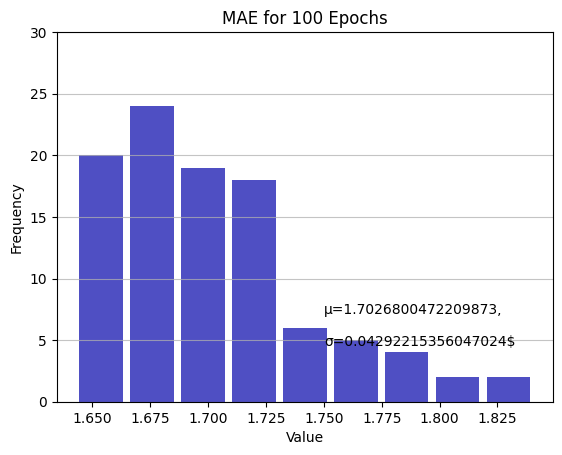

In [9]:
# Mean absolute error, no early stop

mean = sum(uni_absolute1) / len(uni_absolute1)
variance = sum([((x - mean) ** 2) for x in uni_absolute1]) / len(uni_absolute1)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=uni_absolute1, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('MAE for 100 Epochs')
maxfreq = m.max()
plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}$'.format(mean,sd))
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 30.0)

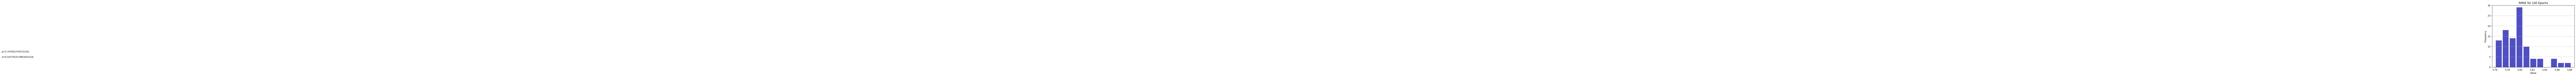

In [10]:
# Root mean squared error, no early stop

mean = sum(uni_root1) / len(uni_root1)
variance = sum([((x - mean) ** 2) for x in uni_root1]) / len(uni_root1)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=uni_root1, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('RMSE for 100 Epochs')
plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}$'.format(mean,sd))
maxfreq = m.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

In [11]:
# 50 epochs

n_epochs = 50
uni_absolute2 = []
uni_root2 = []

for i in range(n):
    train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=True)

    model = LSTMModel(input_size=config["model"]["input_size"], hidden_layer_size=config["model"]["lstm_size"], num_layers=config["model"]["num_lstm_layers"], output_size=1, dropout=config["model"]["dropout"])
    model = model.to(config["training"]["device"])

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=config["training"]["learning_rate"], betas=(0.9, 0.98), eps=1e-9)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=config["training"]["scheduler_step_size"], gamma=0.1)

    for epoch in range(n_epochs):
        loss_train, lr_train = run_epoch(train_dataloader, is_training=True)
        loss_val, lr_val = run_epoch(val_dataloader)
        scheduler.step()

        print('Epoch[{}/{}] | loss train:{:.6f}, test:{:.6f} | lr:{:.6f}'
                  .format(epoch+1, config["training"]["num_epoch"], loss_train, loss_val, lr_train))
        
    train_dataloader = DataLoader(train_dataset, batch_size=config["training"]["batch_size"], shuffle=False)
    val_dataloader = DataLoader(val_dataset, batch_size=config["training"]["batch_size"], shuffle=False)

    model.eval()
    
    predicted_train = np.array([])

    for idx, (x, y) in enumerate(train_dataloader):
        x = x.to(config["training"]["device"])
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_train = np.concatenate((predicted_train, out))

    predicted_val = np.array([])

    for idx, (x, y) in enumerate(val_dataloader):
        x = x.to(config["training"]["device"])
        out = model(x)
        out = out.cpu().detach().numpy()
        predicted_val = np.concatenate((predicted_val, out))

    data_y_train_pred = np.zeros(num_data_points)
    data_y_val_pred = np.zeros(num_data_points)

    data_y_train_pred[config["data"]["window_size"]:split_index+config["data"]["window_size"]] = scaler.inverse_transform(predicted_train)
    data_y_val_pred[split_index+config["data"]["window_size"]:] = scaler.inverse_transform(predicted_val)

    mae = mean_absolute_error(close_price_data, data_y_train_pred + data_y_val_pred)
    print("Mean absolute error: ", mae)

    rmse = np.sqrt(mean_squared_error(close_price_data, data_y_train_pred+data_y_val_pred))
    print("Root mean squared error: ", rmse)
    
    uni_absolute2.append(mae)
    uni_root2.append(rmse)


Epoch[1/100] | loss train:0.041617, test:0.000789 | lr:0.010000
Epoch[2/100] | loss train:0.012797, test:0.005335 | lr:0.010000
Epoch[3/100] | loss train:0.011997, test:0.005244 | lr:0.010000
Epoch[4/100] | loss train:0.011014, test:0.009217 | lr:0.010000
Epoch[5/100] | loss train:0.011866, test:0.000559 | lr:0.010000
Epoch[6/100] | loss train:0.010343, test:0.002962 | lr:0.010000
Epoch[7/100] | loss train:0.008132, test:0.000624 | lr:0.010000
Epoch[8/100] | loss train:0.010007, test:0.004586 | lr:0.010000
Epoch[9/100] | loss train:0.011973, test:0.005928 | lr:0.010000
Epoch[10/100] | loss train:0.010737, test:0.007365 | lr:0.010000
Epoch[11/100] | loss train:0.011237, test:0.004760 | lr:0.010000
Epoch[12/100] | loss train:0.008832, test:0.004924 | lr:0.010000
Epoch[13/100] | loss train:0.008923, test:0.000558 | lr:0.010000
Epoch[14/100] | loss train:0.007558, test:0.000316 | lr:0.010000
Epoch[15/100] | loss train:0.007727, test:0.000429 | lr:0.010000
Epoch[16/100] | loss train:0.00881

Epoch[25/100] | loss train:0.007063, test:0.000434 | lr:0.010000
Epoch[26/100] | loss train:0.007124, test:0.000429 | lr:0.010000
Epoch[27/100] | loss train:0.007774, test:0.003818 | lr:0.010000
Epoch[28/100] | loss train:0.009424, test:0.000528 | lr:0.010000
Epoch[29/100] | loss train:0.006092, test:0.000523 | lr:0.010000
Epoch[30/100] | loss train:0.008060, test:0.000768 | lr:0.010000
Epoch[31/100] | loss train:0.007625, test:0.000627 | lr:0.010000
Epoch[32/100] | loss train:0.010738, test:0.000798 | lr:0.010000
Epoch[33/100] | loss train:0.008610, test:0.000608 | lr:0.010000
Epoch[34/100] | loss train:0.006603, test:0.000424 | lr:0.010000
Epoch[35/100] | loss train:0.007153, test:0.002688 | lr:0.010000
Epoch[36/100] | loss train:0.007619, test:0.001695 | lr:0.010000
Epoch[37/100] | loss train:0.006496, test:0.000482 | lr:0.010000
Epoch[38/100] | loss train:0.006671, test:0.001038 | lr:0.010000
Epoch[39/100] | loss train:0.008367, test:0.001028 | lr:0.010000
Epoch[40/100] | loss trai

Epoch[49/100] | loss train:0.005207, test:0.000620 | lr:0.001000
Epoch[50/100] | loss train:0.010718, test:0.000301 | lr:0.001000
Mean absolute error:  1.7230166371455304
Root mean squared error:  5.812556350633915
Epoch[1/100] | loss train:0.073173, test:0.001055 | lr:0.010000
Epoch[2/100] | loss train:0.012877, test:0.000519 | lr:0.010000
Epoch[3/100] | loss train:0.011245, test:0.001937 | lr:0.010000
Epoch[4/100] | loss train:0.009328, test:0.000294 | lr:0.010000
Epoch[5/100] | loss train:0.009263, test:0.001359 | lr:0.010000
Epoch[6/100] | loss train:0.011773, test:0.002036 | lr:0.010000
Epoch[7/100] | loss train:0.011134, test:0.004316 | lr:0.010000
Epoch[8/100] | loss train:0.009239, test:0.000404 | lr:0.010000
Epoch[9/100] | loss train:0.007684, test:0.000749 | lr:0.010000
Epoch[10/100] | loss train:0.009497, test:0.002214 | lr:0.010000
Epoch[11/100] | loss train:0.008973, test:0.000419 | lr:0.010000
Epoch[12/100] | loss train:0.007465, test:0.000352 | lr:0.010000
Epoch[13/100] 

Epoch[22/100] | loss train:0.007204, test:0.000709 | lr:0.010000
Epoch[23/100] | loss train:0.007965, test:0.003561 | lr:0.010000
Epoch[24/100] | loss train:0.008020, test:0.005077 | lr:0.010000
Epoch[25/100] | loss train:0.008488, test:0.000595 | lr:0.010000
Epoch[26/100] | loss train:0.007942, test:0.000681 | lr:0.010000
Epoch[27/100] | loss train:0.008099, test:0.002204 | lr:0.010000
Epoch[28/100] | loss train:0.007754, test:0.000505 | lr:0.010000
Epoch[29/100] | loss train:0.008314, test:0.000433 | lr:0.010000
Epoch[30/100] | loss train:0.008237, test:0.000444 | lr:0.010000
Epoch[31/100] | loss train:0.006811, test:0.000512 | lr:0.010000
Epoch[32/100] | loss train:0.008489, test:0.000653 | lr:0.010000
Epoch[33/100] | loss train:0.007100, test:0.000462 | lr:0.010000
Epoch[34/100] | loss train:0.008712, test:0.000846 | lr:0.010000
Epoch[35/100] | loss train:0.008533, test:0.000702 | lr:0.010000
Epoch[36/100] | loss train:0.007013, test:0.002914 | lr:0.010000
Epoch[37/100] | loss trai

Epoch[46/100] | loss train:0.005816, test:0.000570 | lr:0.001000
Epoch[47/100] | loss train:0.005823, test:0.000540 | lr:0.001000
Epoch[48/100] | loss train:0.004756, test:0.000470 | lr:0.001000
Epoch[49/100] | loss train:0.005563, test:0.000415 | lr:0.001000
Epoch[50/100] | loss train:0.004654, test:0.000529 | lr:0.001000
Mean absolute error:  2.060969374340822
Root mean squared error:  6.09641860520588
Epoch[1/100] | loss train:0.060347, test:0.000400 | lr:0.010000
Epoch[2/100] | loss train:0.012143, test:0.001602 | lr:0.010000
Epoch[3/100] | loss train:0.010080, test:0.000839 | lr:0.010000
Epoch[4/100] | loss train:0.010203, test:0.000491 | lr:0.010000
Epoch[5/100] | loss train:0.008616, test:0.002521 | lr:0.010000
Epoch[6/100] | loss train:0.012651, test:0.002782 | lr:0.010000
Epoch[7/100] | loss train:0.011581, test:0.000485 | lr:0.010000
Epoch[8/100] | loss train:0.007833, test:0.009756 | lr:0.010000
Epoch[9/100] | loss train:0.009026, test:0.000653 | lr:0.010000
Epoch[10/100] | 

Epoch[19/100] | loss train:0.008088, test:0.000413 | lr:0.010000
Epoch[20/100] | loss train:0.008415, test:0.004067 | lr:0.010000
Epoch[21/100] | loss train:0.009811, test:0.000499 | lr:0.010000
Epoch[22/100] | loss train:0.007816, test:0.000379 | lr:0.010000
Epoch[23/100] | loss train:0.007604, test:0.005336 | lr:0.010000
Epoch[24/100] | loss train:0.011345, test:0.004213 | lr:0.010000
Epoch[25/100] | loss train:0.010078, test:0.000856 | lr:0.010000
Epoch[26/100] | loss train:0.007954, test:0.000679 | lr:0.010000
Epoch[27/100] | loss train:0.006993, test:0.000651 | lr:0.010000
Epoch[28/100] | loss train:0.007730, test:0.000698 | lr:0.010000
Epoch[29/100] | loss train:0.006778, test:0.000581 | lr:0.010000
Epoch[30/100] | loss train:0.007822, test:0.000916 | lr:0.010000
Epoch[31/100] | loss train:0.007197, test:0.000798 | lr:0.010000
Epoch[32/100] | loss train:0.012233, test:0.001840 | lr:0.010000
Epoch[33/100] | loss train:0.010306, test:0.001465 | lr:0.010000
Epoch[34/100] | loss trai

Epoch[43/100] | loss train:0.005573, test:0.000382 | lr:0.001000
Epoch[44/100] | loss train:0.005202, test:0.000406 | lr:0.001000
Epoch[45/100] | loss train:0.005518, test:0.000424 | lr:0.001000
Epoch[46/100] | loss train:0.005773, test:0.000370 | lr:0.001000
Epoch[47/100] | loss train:0.005018, test:0.000419 | lr:0.001000
Epoch[48/100] | loss train:0.005356, test:0.000610 | lr:0.001000
Epoch[49/100] | loss train:0.005643, test:0.000375 | lr:0.001000
Epoch[50/100] | loss train:0.008304, test:0.000393 | lr:0.001000
Mean absolute error:  1.800683111894242
Root mean squared error:  5.883818938867948
Epoch[1/100] | loss train:0.060226, test:0.006278 | lr:0.010000
Epoch[2/100] | loss train:0.012012, test:0.000508 | lr:0.010000
Epoch[3/100] | loss train:0.013226, test:0.002088 | lr:0.010000
Epoch[4/100] | loss train:0.009451, test:0.000858 | lr:0.010000
Epoch[5/100] | loss train:0.008802, test:0.000497 | lr:0.010000
Epoch[6/100] | loss train:0.012299, test:0.000327 | lr:0.010000
Epoch[7/100]

Epoch[16/100] | loss train:0.007383, test:0.000889 | lr:0.010000
Epoch[17/100] | loss train:0.008002, test:0.000509 | lr:0.010000
Epoch[18/100] | loss train:0.008633, test:0.001384 | lr:0.010000
Epoch[19/100] | loss train:0.007385, test:0.001694 | lr:0.010000
Epoch[20/100] | loss train:0.007477, test:0.001725 | lr:0.010000
Epoch[21/100] | loss train:0.008390, test:0.000441 | lr:0.010000
Epoch[22/100] | loss train:0.010342, test:0.000867 | lr:0.010000
Epoch[23/100] | loss train:0.007250, test:0.000614 | lr:0.010000
Epoch[24/100] | loss train:0.009584, test:0.000622 | lr:0.010000
Epoch[25/100] | loss train:0.008420, test:0.000624 | lr:0.010000
Epoch[26/100] | loss train:0.007852, test:0.000704 | lr:0.010000
Epoch[27/100] | loss train:0.008012, test:0.000814 | lr:0.010000
Epoch[28/100] | loss train:0.006647, test:0.000325 | lr:0.010000
Epoch[29/100] | loss train:0.007425, test:0.000491 | lr:0.010000
Epoch[30/100] | loss train:0.008109, test:0.004217 | lr:0.010000
Epoch[31/100] | loss trai

Epoch[40/100] | loss train:0.007160, test:0.000415 | lr:0.010000
Epoch[41/100] | loss train:0.005327, test:0.000548 | lr:0.001000
Epoch[42/100] | loss train:0.005277, test:0.000329 | lr:0.001000
Epoch[43/100] | loss train:0.005877, test:0.000307 | lr:0.001000
Epoch[44/100] | loss train:0.011240, test:0.000288 | lr:0.001000
Epoch[45/100] | loss train:0.004965, test:0.000333 | lr:0.001000
Epoch[46/100] | loss train:0.005469, test:0.000425 | lr:0.001000
Epoch[47/100] | loss train:0.005732, test:0.000616 | lr:0.001000
Epoch[48/100] | loss train:0.005458, test:0.000318 | lr:0.001000
Epoch[49/100] | loss train:0.005089, test:0.000292 | lr:0.001000
Epoch[50/100] | loss train:0.005440, test:0.000325 | lr:0.001000
Mean absolute error:  1.932041259042894
Root mean squared error:  5.863616112864714
Epoch[1/100] | loss train:0.049572, test:0.000615 | lr:0.010000
Epoch[2/100] | loss train:0.010293, test:0.000706 | lr:0.010000
Epoch[3/100] | loss train:0.008929, test:0.000550 | lr:0.010000
Epoch[4/1

Epoch[13/100] | loss train:0.009919, test:0.000454 | lr:0.010000
Epoch[14/100] | loss train:0.011039, test:0.007076 | lr:0.010000
Epoch[15/100] | loss train:0.008586, test:0.000949 | lr:0.010000
Epoch[16/100] | loss train:0.008991, test:0.001664 | lr:0.010000
Epoch[17/100] | loss train:0.007940, test:0.001079 | lr:0.010000
Epoch[18/100] | loss train:0.006814, test:0.000291 | lr:0.010000
Epoch[19/100] | loss train:0.007018, test:0.000597 | lr:0.010000
Epoch[20/100] | loss train:0.007849, test:0.002584 | lr:0.010000
Epoch[21/100] | loss train:0.008042, test:0.002341 | lr:0.010000
Epoch[22/100] | loss train:0.008238, test:0.000549 | lr:0.010000
Epoch[23/100] | loss train:0.007426, test:0.002927 | lr:0.010000
Epoch[24/100] | loss train:0.008012, test:0.000756 | lr:0.010000
Epoch[25/100] | loss train:0.007925, test:0.001569 | lr:0.010000
Epoch[26/100] | loss train:0.006684, test:0.000434 | lr:0.010000
Epoch[27/100] | loss train:0.006791, test:0.001817 | lr:0.010000
Epoch[28/100] | loss trai

Epoch[37/100] | loss train:0.007057, test:0.000715 | lr:0.010000
Epoch[38/100] | loss train:0.006626, test:0.001145 | lr:0.010000
Epoch[39/100] | loss train:0.011238, test:0.000975 | lr:0.010000
Epoch[40/100] | loss train:0.008280, test:0.000372 | lr:0.010000
Epoch[41/100] | loss train:0.005424, test:0.000452 | lr:0.001000
Epoch[42/100] | loss train:0.010523, test:0.000371 | lr:0.001000
Epoch[43/100] | loss train:0.005619, test:0.000402 | lr:0.001000
Epoch[44/100] | loss train:0.005203, test:0.000374 | lr:0.001000
Epoch[45/100] | loss train:0.005695, test:0.000411 | lr:0.001000
Epoch[46/100] | loss train:0.005445, test:0.000454 | lr:0.001000
Epoch[47/100] | loss train:0.005911, test:0.000467 | lr:0.001000
Epoch[48/100] | loss train:0.005094, test:0.000343 | lr:0.001000
Epoch[49/100] | loss train:0.006114, test:0.000344 | lr:0.001000
Epoch[50/100] | loss train:0.005659, test:0.000325 | lr:0.001000
Mean absolute error:  2.0173447029582903
Root mean squared error:  5.873798544409702
Epoch

Epoch[10/100] | loss train:0.008939, test:0.001718 | lr:0.010000
Epoch[11/100] | loss train:0.011137, test:0.000475 | lr:0.010000
Epoch[12/100] | loss train:0.008785, test:0.000888 | lr:0.010000
Epoch[13/100] | loss train:0.009905, test:0.000703 | lr:0.010000
Epoch[14/100] | loss train:0.007467, test:0.000485 | lr:0.010000
Epoch[15/100] | loss train:0.009302, test:0.002158 | lr:0.010000
Epoch[16/100] | loss train:0.008533, test:0.000355 | lr:0.010000
Epoch[17/100] | loss train:0.008769, test:0.000673 | lr:0.010000
Epoch[18/100] | loss train:0.007676, test:0.000620 | lr:0.010000
Epoch[19/100] | loss train:0.008583, test:0.000417 | lr:0.010000
Epoch[20/100] | loss train:0.007914, test:0.001908 | lr:0.010000
Epoch[21/100] | loss train:0.008478, test:0.000755 | lr:0.010000
Epoch[22/100] | loss train:0.007831, test:0.000373 | lr:0.010000
Epoch[23/100] | loss train:0.008866, test:0.001084 | lr:0.010000
Epoch[24/100] | loss train:0.007730, test:0.001203 | lr:0.010000
Epoch[25/100] | loss trai

Epoch[34/100] | loss train:0.008719, test:0.002483 | lr:0.010000
Epoch[35/100] | loss train:0.008096, test:0.000692 | lr:0.010000
Epoch[36/100] | loss train:0.007682, test:0.003057 | lr:0.010000
Epoch[37/100] | loss train:0.008561, test:0.002791 | lr:0.010000
Epoch[38/100] | loss train:0.007433, test:0.005032 | lr:0.010000
Epoch[39/100] | loss train:0.007976, test:0.002642 | lr:0.010000
Epoch[40/100] | loss train:0.007023, test:0.000394 | lr:0.010000
Epoch[41/100] | loss train:0.006057, test:0.000341 | lr:0.001000
Epoch[42/100] | loss train:0.006293, test:0.000396 | lr:0.001000
Epoch[43/100] | loss train:0.005121, test:0.000339 | lr:0.001000
Epoch[44/100] | loss train:0.008586, test:0.000358 | lr:0.001000
Epoch[45/100] | loss train:0.006131, test:0.000327 | lr:0.001000
Epoch[46/100] | loss train:0.006009, test:0.000331 | lr:0.001000
Epoch[47/100] | loss train:0.005669, test:0.000331 | lr:0.001000
Epoch[48/100] | loss train:0.005804, test:0.000343 | lr:0.001000
Epoch[49/100] | loss trai

Epoch[7/100] | loss train:0.009108, test:0.001143 | lr:0.010000
Epoch[8/100] | loss train:0.009305, test:0.002266 | lr:0.010000
Epoch[9/100] | loss train:0.018075, test:0.002064 | lr:0.010000
Epoch[10/100] | loss train:0.010946, test:0.000684 | lr:0.010000
Epoch[11/100] | loss train:0.009046, test:0.005351 | lr:0.010000
Epoch[12/100] | loss train:0.009479, test:0.003910 | lr:0.010000
Epoch[13/100] | loss train:0.008318, test:0.000600 | lr:0.010000
Epoch[14/100] | loss train:0.007912, test:0.001170 | lr:0.010000
Epoch[15/100] | loss train:0.012612, test:0.000732 | lr:0.010000
Epoch[16/100] | loss train:0.010904, test:0.003260 | lr:0.010000
Epoch[17/100] | loss train:0.010335, test:0.000800 | lr:0.010000
Epoch[18/100] | loss train:0.007257, test:0.000953 | lr:0.010000
Epoch[19/100] | loss train:0.007834, test:0.000412 | lr:0.010000
Epoch[20/100] | loss train:0.008341, test:0.001532 | lr:0.010000
Epoch[21/100] | loss train:0.008568, test:0.000518 | lr:0.010000
Epoch[22/100] | loss train:0

Epoch[31/100] | loss train:0.009250, test:0.000404 | lr:0.010000
Epoch[32/100] | loss train:0.008707, test:0.001333 | lr:0.010000
Epoch[33/100] | loss train:0.007132, test:0.000599 | lr:0.010000
Epoch[34/100] | loss train:0.006378, test:0.000740 | lr:0.010000
Epoch[35/100] | loss train:0.007783, test:0.000387 | lr:0.010000
Epoch[36/100] | loss train:0.007016, test:0.000988 | lr:0.010000
Epoch[37/100] | loss train:0.007823, test:0.000384 | lr:0.010000
Epoch[38/100] | loss train:0.007025, test:0.000478 | lr:0.010000
Epoch[39/100] | loss train:0.007373, test:0.001145 | lr:0.010000
Epoch[40/100] | loss train:0.008092, test:0.000742 | lr:0.010000
Epoch[41/100] | loss train:0.005688, test:0.000407 | lr:0.001000
Epoch[42/100] | loss train:0.005918, test:0.000448 | lr:0.001000
Epoch[43/100] | loss train:0.005699, test:0.000494 | lr:0.001000
Epoch[44/100] | loss train:0.005237, test:0.000347 | lr:0.001000
Epoch[45/100] | loss train:0.005254, test:0.000398 | lr:0.001000
Epoch[46/100] | loss trai

Epoch[4/100] | loss train:0.017778, test:0.000314 | lr:0.010000
Epoch[5/100] | loss train:0.008898, test:0.000487 | lr:0.010000
Epoch[6/100] | loss train:0.007236, test:0.000887 | lr:0.010000
Epoch[7/100] | loss train:0.009031, test:0.004127 | lr:0.010000
Epoch[8/100] | loss train:0.008276, test:0.000542 | lr:0.010000
Epoch[9/100] | loss train:0.008839, test:0.000710 | lr:0.010000
Epoch[10/100] | loss train:0.009051, test:0.002742 | lr:0.010000
Epoch[11/100] | loss train:0.008043, test:0.002584 | lr:0.010000
Epoch[12/100] | loss train:0.008091, test:0.003350 | lr:0.010000
Epoch[13/100] | loss train:0.007943, test:0.000758 | lr:0.010000
Epoch[14/100] | loss train:0.007445, test:0.000669 | lr:0.010000
Epoch[15/100] | loss train:0.008891, test:0.001363 | lr:0.010000
Epoch[16/100] | loss train:0.008545, test:0.000838 | lr:0.010000
Epoch[17/100] | loss train:0.007189, test:0.000388 | lr:0.010000
Epoch[18/100] | loss train:0.007592, test:0.000500 | lr:0.010000
Epoch[19/100] | loss train:0.01

Epoch[28/100] | loss train:0.008077, test:0.001033 | lr:0.010000
Epoch[29/100] | loss train:0.006796, test:0.003696 | lr:0.010000
Epoch[30/100] | loss train:0.007416, test:0.001182 | lr:0.010000
Epoch[31/100] | loss train:0.008012, test:0.002133 | lr:0.010000
Epoch[32/100] | loss train:0.007770, test:0.001017 | lr:0.010000
Epoch[33/100] | loss train:0.008219, test:0.000391 | lr:0.010000
Epoch[34/100] | loss train:0.006556, test:0.000442 | lr:0.010000
Epoch[35/100] | loss train:0.005949, test:0.000397 | lr:0.010000
Epoch[36/100] | loss train:0.006612, test:0.000715 | lr:0.010000
Epoch[37/100] | loss train:0.008573, test:0.000703 | lr:0.010000
Epoch[38/100] | loss train:0.007424, test:0.000581 | lr:0.010000
Epoch[39/100] | loss train:0.010831, test:0.000529 | lr:0.010000
Epoch[40/100] | loss train:0.006990, test:0.000476 | lr:0.010000
Epoch[41/100] | loss train:0.008270, test:0.000495 | lr:0.001000
Epoch[42/100] | loss train:0.009946, test:0.000376 | lr:0.001000
Epoch[43/100] | loss trai

Epoch[1/100] | loss train:0.055230, test:0.000663 | lr:0.010000
Epoch[2/100] | loss train:0.011376, test:0.003030 | lr:0.010000
Epoch[3/100] | loss train:0.011314, test:0.004330 | lr:0.010000
Epoch[4/100] | loss train:0.009641, test:0.003830 | lr:0.010000
Epoch[5/100] | loss train:0.009812, test:0.002773 | lr:0.010000
Epoch[6/100] | loss train:0.009851, test:0.004119 | lr:0.010000
Epoch[7/100] | loss train:0.009596, test:0.000957 | lr:0.010000
Epoch[8/100] | loss train:0.008343, test:0.000594 | lr:0.010000
Epoch[9/100] | loss train:0.007932, test:0.000348 | lr:0.010000
Epoch[10/100] | loss train:0.007213, test:0.001003 | lr:0.010000
Epoch[11/100] | loss train:0.010138, test:0.005749 | lr:0.010000
Epoch[12/100] | loss train:0.009548, test:0.000565 | lr:0.010000
Epoch[13/100] | loss train:0.009203, test:0.002121 | lr:0.010000
Epoch[14/100] | loss train:0.007292, test:0.000430 | lr:0.010000
Epoch[15/100] | loss train:0.009202, test:0.000547 | lr:0.010000
Epoch[16/100] | loss train:0.00830

Epoch[25/100] | loss train:0.007537, test:0.003144 | lr:0.010000
Epoch[26/100] | loss train:0.011792, test:0.000748 | lr:0.010000
Epoch[27/100] | loss train:0.008286, test:0.000469 | lr:0.010000
Epoch[28/100] | loss train:0.006750, test:0.000990 | lr:0.010000
Epoch[29/100] | loss train:0.006931, test:0.001729 | lr:0.010000
Epoch[30/100] | loss train:0.006841, test:0.001494 | lr:0.010000
Epoch[31/100] | loss train:0.008265, test:0.000641 | lr:0.010000
Epoch[32/100] | loss train:0.007778, test:0.002114 | lr:0.010000
Epoch[33/100] | loss train:0.007411, test:0.001086 | lr:0.010000
Epoch[34/100] | loss train:0.011659, test:0.001728 | lr:0.010000
Epoch[35/100] | loss train:0.011722, test:0.001061 | lr:0.010000
Epoch[36/100] | loss train:0.007789, test:0.000506 | lr:0.010000
Epoch[37/100] | loss train:0.007337, test:0.000469 | lr:0.010000
Epoch[38/100] | loss train:0.009478, test:0.000426 | lr:0.010000
Epoch[39/100] | loss train:0.006930, test:0.002333 | lr:0.010000
Epoch[40/100] | loss trai

Epoch[49/100] | loss train:0.006070, test:0.000393 | lr:0.001000
Epoch[50/100] | loss train:0.005551, test:0.000380 | lr:0.001000
Mean absolute error:  1.7552094969545255
Root mean squared error:  5.848438424098581
Epoch[1/100] | loss train:0.069496, test:0.001162 | lr:0.010000
Epoch[2/100] | loss train:0.011205, test:0.000825 | lr:0.010000
Epoch[3/100] | loss train:0.009842, test:0.001418 | lr:0.010000
Epoch[4/100] | loss train:0.009626, test:0.002583 | lr:0.010000
Epoch[5/100] | loss train:0.010119, test:0.001446 | lr:0.010000
Epoch[6/100] | loss train:0.009757, test:0.000518 | lr:0.010000
Epoch[7/100] | loss train:0.007844, test:0.003535 | lr:0.010000
Epoch[8/100] | loss train:0.009999, test:0.000806 | lr:0.010000
Epoch[9/100] | loss train:0.008649, test:0.000434 | lr:0.010000
Epoch[10/100] | loss train:0.007009, test:0.000330 | lr:0.010000
Epoch[11/100] | loss train:0.008501, test:0.000348 | lr:0.010000
Epoch[12/100] | loss train:0.009677, test:0.001376 | lr:0.010000
Epoch[13/100] 

Epoch[22/100] | loss train:0.006581, test:0.000784 | lr:0.010000
Epoch[23/100] | loss train:0.006450, test:0.000691 | lr:0.010000
Epoch[24/100] | loss train:0.008517, test:0.000520 | lr:0.010000
Epoch[25/100] | loss train:0.009056, test:0.001828 | lr:0.010000
Epoch[26/100] | loss train:0.007980, test:0.000977 | lr:0.010000
Epoch[27/100] | loss train:0.006565, test:0.000382 | lr:0.010000
Epoch[28/100] | loss train:0.007306, test:0.004612 | lr:0.010000
Epoch[29/100] | loss train:0.010166, test:0.001166 | lr:0.010000
Epoch[30/100] | loss train:0.008194, test:0.001870 | lr:0.010000
Epoch[31/100] | loss train:0.007322, test:0.002926 | lr:0.010000
Epoch[32/100] | loss train:0.007069, test:0.000648 | lr:0.010000
Epoch[33/100] | loss train:0.007674, test:0.000744 | lr:0.010000
Epoch[34/100] | loss train:0.006624, test:0.000497 | lr:0.010000
Epoch[35/100] | loss train:0.006643, test:0.000339 | lr:0.010000
Epoch[36/100] | loss train:0.007394, test:0.002241 | lr:0.010000
Epoch[37/100] | loss trai

Epoch[46/100] | loss train:0.005320, test:0.000382 | lr:0.001000
Epoch[47/100] | loss train:0.005332, test:0.000370 | lr:0.001000
Epoch[48/100] | loss train:0.004955, test:0.000356 | lr:0.001000
Epoch[49/100] | loss train:0.005569, test:0.000355 | lr:0.001000
Epoch[50/100] | loss train:0.005749, test:0.000309 | lr:0.001000
Mean absolute error:  1.9326370558580306
Root mean squared error:  5.858623016580412
Epoch[1/100] | loss train:0.052700, test:0.003204 | lr:0.010000
Epoch[2/100] | loss train:0.011890, test:0.001269 | lr:0.010000
Epoch[3/100] | loss train:0.012388, test:0.000318 | lr:0.010000
Epoch[4/100] | loss train:0.011509, test:0.000299 | lr:0.010000
Epoch[5/100] | loss train:0.008953, test:0.001556 | lr:0.010000
Epoch[6/100] | loss train:0.009342, test:0.004761 | lr:0.010000
Epoch[7/100] | loss train:0.009231, test:0.000952 | lr:0.010000
Epoch[8/100] | loss train:0.007512, test:0.000670 | lr:0.010000
Epoch[9/100] | loss train:0.009324, test:0.000893 | lr:0.010000
Epoch[10/100] 

Epoch[19/100] | loss train:0.008090, test:0.000923 | lr:0.010000
Epoch[20/100] | loss train:0.013099, test:0.002516 | lr:0.010000
Epoch[21/100] | loss train:0.008589, test:0.000392 | lr:0.010000
Epoch[22/100] | loss train:0.007489, test:0.000378 | lr:0.010000
Epoch[23/100] | loss train:0.006639, test:0.001141 | lr:0.010000
Epoch[24/100] | loss train:0.008026, test:0.000918 | lr:0.010000
Epoch[25/100] | loss train:0.008736, test:0.001034 | lr:0.010000
Epoch[26/100] | loss train:0.009787, test:0.000432 | lr:0.010000
Epoch[27/100] | loss train:0.007471, test:0.000446 | lr:0.010000
Epoch[28/100] | loss train:0.007411, test:0.000437 | lr:0.010000
Epoch[29/100] | loss train:0.007130, test:0.001569 | lr:0.010000
Epoch[30/100] | loss train:0.008818, test:0.002112 | lr:0.010000
Epoch[31/100] | loss train:0.009930, test:0.000397 | lr:0.010000
Epoch[32/100] | loss train:0.009444, test:0.000986 | lr:0.010000
Epoch[33/100] | loss train:0.007191, test:0.001263 | lr:0.010000
Epoch[34/100] | loss trai

Epoch[43/100] | loss train:0.005310, test:0.000322 | lr:0.001000
Epoch[44/100] | loss train:0.007213, test:0.000377 | lr:0.001000
Epoch[45/100] | loss train:0.004871, test:0.000332 | lr:0.001000
Epoch[46/100] | loss train:0.007229, test:0.000326 | lr:0.001000
Epoch[47/100] | loss train:0.004965, test:0.000300 | lr:0.001000
Epoch[48/100] | loss train:0.007954, test:0.000311 | lr:0.001000
Epoch[49/100] | loss train:0.005127, test:0.000310 | lr:0.001000
Epoch[50/100] | loss train:0.004577, test:0.000298 | lr:0.001000
Mean absolute error:  1.8229924479079236
Root mean squared error:  5.813977216309009
Epoch[1/100] | loss train:0.050999, test:0.000680 | lr:0.010000
Epoch[2/100] | loss train:0.009815, test:0.000609 | lr:0.010000
Epoch[3/100] | loss train:0.009516, test:0.003249 | lr:0.010000
Epoch[4/100] | loss train:0.008805, test:0.001129 | lr:0.010000
Epoch[5/100] | loss train:0.008358, test:0.000390 | lr:0.010000
Epoch[6/100] | loss train:0.009815, test:0.000373 | lr:0.010000
Epoch[7/100

Epoch[16/100] | loss train:0.006738, test:0.001000 | lr:0.010000
Epoch[17/100] | loss train:0.008026, test:0.003680 | lr:0.010000
Epoch[18/100] | loss train:0.009772, test:0.000812 | lr:0.010000
Epoch[19/100] | loss train:0.007683, test:0.000622 | lr:0.010000
Epoch[20/100] | loss train:0.007751, test:0.000960 | lr:0.010000
Epoch[21/100] | loss train:0.007107, test:0.000558 | lr:0.010000
Epoch[22/100] | loss train:0.008457, test:0.001312 | lr:0.010000
Epoch[23/100] | loss train:0.010123, test:0.000706 | lr:0.010000
Epoch[24/100] | loss train:0.007391, test:0.008448 | lr:0.010000
Epoch[25/100] | loss train:0.008593, test:0.003521 | lr:0.010000
Epoch[26/100] | loss train:0.008746, test:0.002358 | lr:0.010000
Epoch[27/100] | loss train:0.009969, test:0.000891 | lr:0.010000
Epoch[28/100] | loss train:0.008010, test:0.001015 | lr:0.010000
Epoch[29/100] | loss train:0.008003, test:0.000521 | lr:0.010000
Epoch[30/100] | loss train:0.008264, test:0.000402 | lr:0.010000
Epoch[31/100] | loss trai

Epoch[40/100] | loss train:0.007476, test:0.000466 | lr:0.010000
Epoch[41/100] | loss train:0.006114, test:0.000565 | lr:0.001000
Epoch[42/100] | loss train:0.006248, test:0.000487 | lr:0.001000
Epoch[43/100] | loss train:0.005564, test:0.000851 | lr:0.001000
Epoch[44/100] | loss train:0.008999, test:0.000395 | lr:0.001000
Epoch[45/100] | loss train:0.005492, test:0.000444 | lr:0.001000
Epoch[46/100] | loss train:0.005446, test:0.000407 | lr:0.001000
Epoch[47/100] | loss train:0.007688, test:0.000370 | lr:0.001000
Epoch[48/100] | loss train:0.006213, test:0.000459 | lr:0.001000
Epoch[49/100] | loss train:0.006036, test:0.000486 | lr:0.001000
Epoch[50/100] | loss train:0.005413, test:0.000423 | lr:0.001000
Mean absolute error:  2.1185721586644912
Root mean squared error:  6.052418442545389
Epoch[1/100] | loss train:0.054915, test:0.001379 | lr:0.010000
Epoch[2/100] | loss train:0.012637, test:0.000728 | lr:0.010000
Epoch[3/100] | loss train:0.009945, test:0.002634 | lr:0.010000
Epoch[4/

Epoch[13/100] | loss train:0.007885, test:0.000739 | lr:0.010000
Epoch[14/100] | loss train:0.007225, test:0.006894 | lr:0.010000
Epoch[15/100] | loss train:0.008158, test:0.000861 | lr:0.010000
Epoch[16/100] | loss train:0.007801, test:0.000388 | lr:0.010000
Epoch[17/100] | loss train:0.007465, test:0.002811 | lr:0.010000
Epoch[18/100] | loss train:0.026272, test:0.000858 | lr:0.010000
Epoch[19/100] | loss train:0.008514, test:0.001278 | lr:0.010000
Epoch[20/100] | loss train:0.008379, test:0.003781 | lr:0.010000
Epoch[21/100] | loss train:0.007359, test:0.001199 | lr:0.010000
Epoch[22/100] | loss train:0.006966, test:0.000583 | lr:0.010000
Epoch[23/100] | loss train:0.008541, test:0.000422 | lr:0.010000
Epoch[24/100] | loss train:0.006116, test:0.000842 | lr:0.010000
Epoch[25/100] | loss train:0.007016, test:0.002636 | lr:0.010000
Epoch[26/100] | loss train:0.007407, test:0.000767 | lr:0.010000
Epoch[27/100] | loss train:0.007370, test:0.000919 | lr:0.010000
Epoch[28/100] | loss trai

Epoch[37/100] | loss train:0.008255, test:0.001669 | lr:0.010000
Epoch[38/100] | loss train:0.007320, test:0.000603 | lr:0.010000
Epoch[39/100] | loss train:0.006372, test:0.000447 | lr:0.010000
Epoch[40/100] | loss train:0.007329, test:0.000701 | lr:0.010000
Epoch[41/100] | loss train:0.005981, test:0.000462 | lr:0.001000
Epoch[42/100] | loss train:0.007532, test:0.000519 | lr:0.001000
Epoch[43/100] | loss train:0.006149, test:0.000461 | lr:0.001000
Epoch[44/100] | loss train:0.005375, test:0.000413 | lr:0.001000
Epoch[45/100] | loss train:0.011013, test:0.000725 | lr:0.001000
Epoch[46/100] | loss train:0.005869, test:0.000448 | lr:0.001000
Epoch[47/100] | loss train:0.005885, test:0.000432 | lr:0.001000
Epoch[48/100] | loss train:0.005418, test:0.000555 | lr:0.001000
Epoch[49/100] | loss train:0.005594, test:0.000427 | lr:0.001000
Epoch[50/100] | loss train:0.005246, test:0.000580 | lr:0.001000
Mean absolute error:  1.9799367227481148
Root mean squared error:  6.0616933941832425
Epoc

Epoch[10/100] | loss train:0.009289, test:0.007155 | lr:0.010000
Epoch[11/100] | loss train:0.008871, test:0.000493 | lr:0.010000
Epoch[12/100] | loss train:0.007896, test:0.003127 | lr:0.010000
Epoch[13/100] | loss train:0.010290, test:0.000502 | lr:0.010000
Epoch[14/100] | loss train:0.008342, test:0.000614 | lr:0.010000
Epoch[15/100] | loss train:0.008392, test:0.000498 | lr:0.010000
Epoch[16/100] | loss train:0.008149, test:0.001411 | lr:0.010000
Epoch[17/100] | loss train:0.007172, test:0.000623 | lr:0.010000
Epoch[18/100] | loss train:0.008090, test:0.000564 | lr:0.010000
Epoch[19/100] | loss train:0.006720, test:0.000917 | lr:0.010000
Epoch[20/100] | loss train:0.011777, test:0.004407 | lr:0.010000
Epoch[21/100] | loss train:0.008130, test:0.000874 | lr:0.010000
Epoch[22/100] | loss train:0.007332, test:0.003184 | lr:0.010000
Epoch[23/100] | loss train:0.006313, test:0.000717 | lr:0.010000
Epoch[24/100] | loss train:0.008113, test:0.001372 | lr:0.010000
Epoch[25/100] | loss trai

Epoch[34/100] | loss train:0.006428, test:0.002463 | lr:0.010000
Epoch[35/100] | loss train:0.007402, test:0.000873 | lr:0.010000
Epoch[36/100] | loss train:0.008642, test:0.000358 | lr:0.010000
Epoch[37/100] | loss train:0.006768, test:0.001051 | lr:0.010000
Epoch[38/100] | loss train:0.006901, test:0.000791 | lr:0.010000
Epoch[39/100] | loss train:0.007856, test:0.000465 | lr:0.010000
Epoch[40/100] | loss train:0.006694, test:0.000365 | lr:0.010000
Epoch[41/100] | loss train:0.010252, test:0.000350 | lr:0.001000
Epoch[42/100] | loss train:0.005642, test:0.000345 | lr:0.001000
Epoch[43/100] | loss train:0.005061, test:0.000346 | lr:0.001000
Epoch[44/100] | loss train:0.005476, test:0.000448 | lr:0.001000
Epoch[45/100] | loss train:0.005890, test:0.000343 | lr:0.001000
Epoch[46/100] | loss train:0.005872, test:0.000378 | lr:0.001000
Epoch[47/100] | loss train:0.005089, test:0.000314 | lr:0.001000
Epoch[48/100] | loss train:0.005528, test:0.000365 | lr:0.001000
Epoch[49/100] | loss trai

Epoch[7/100] | loss train:0.008901, test:0.001488 | lr:0.010000
Epoch[8/100] | loss train:0.008537, test:0.003832 | lr:0.010000
Epoch[9/100] | loss train:0.008613, test:0.000393 | lr:0.010000
Epoch[10/100] | loss train:0.007069, test:0.002561 | lr:0.010000
Epoch[11/100] | loss train:0.009793, test:0.000348 | lr:0.010000
Epoch[12/100] | loss train:0.008370, test:0.000323 | lr:0.010000
Epoch[13/100] | loss train:0.008235, test:0.000849 | lr:0.010000
Epoch[14/100] | loss train:0.008256, test:0.000474 | lr:0.010000
Epoch[15/100] | loss train:0.009773, test:0.000628 | lr:0.010000
Epoch[16/100] | loss train:0.008643, test:0.000475 | lr:0.010000
Epoch[17/100] | loss train:0.007605, test:0.000700 | lr:0.010000
Epoch[18/100] | loss train:0.009076, test:0.000730 | lr:0.010000
Epoch[19/100] | loss train:0.009645, test:0.000406 | lr:0.010000
Epoch[20/100] | loss train:0.007798, test:0.001611 | lr:0.010000
Epoch[21/100] | loss train:0.007665, test:0.000342 | lr:0.010000
Epoch[22/100] | loss train:0

Epoch[31/100] | loss train:0.012803, test:0.002302 | lr:0.010000
Epoch[32/100] | loss train:0.008172, test:0.003362 | lr:0.010000
Epoch[33/100] | loss train:0.006952, test:0.000632 | lr:0.010000
Epoch[34/100] | loss train:0.007986, test:0.000887 | lr:0.010000
Epoch[35/100] | loss train:0.007732, test:0.000434 | lr:0.010000
Epoch[36/100] | loss train:0.006579, test:0.000318 | lr:0.010000
Epoch[37/100] | loss train:0.006105, test:0.000440 | lr:0.010000
Epoch[38/100] | loss train:0.007270, test:0.000331 | lr:0.010000
Epoch[39/100] | loss train:0.006817, test:0.000695 | lr:0.010000
Epoch[40/100] | loss train:0.006736, test:0.000391 | lr:0.010000
Epoch[41/100] | loss train:0.005653, test:0.000354 | lr:0.001000
Epoch[42/100] | loss train:0.006110, test:0.000336 | lr:0.001000
Epoch[43/100] | loss train:0.005246, test:0.000280 | lr:0.001000
Epoch[44/100] | loss train:0.005835, test:0.000281 | lr:0.001000
Epoch[45/100] | loss train:0.004780, test:0.000299 | lr:0.001000
Epoch[46/100] | loss trai

Epoch[4/100] | loss train:0.009356, test:0.000892 | lr:0.010000
Epoch[5/100] | loss train:0.009409, test:0.000375 | lr:0.010000
Epoch[6/100] | loss train:0.009328, test:0.000701 | lr:0.010000
Epoch[7/100] | loss train:0.007381, test:0.002528 | lr:0.010000
Epoch[8/100] | loss train:0.010537, test:0.000341 | lr:0.010000
Epoch[9/100] | loss train:0.008974, test:0.004547 | lr:0.010000
Epoch[10/100] | loss train:0.009351, test:0.000992 | lr:0.010000
Epoch[11/100] | loss train:0.007492, test:0.001288 | lr:0.010000
Epoch[12/100] | loss train:0.011118, test:0.012364 | lr:0.010000
Epoch[13/100] | loss train:0.010952, test:0.000745 | lr:0.010000
Epoch[14/100] | loss train:0.006874, test:0.007934 | lr:0.010000
Epoch[15/100] | loss train:0.007994, test:0.001975 | lr:0.010000
Epoch[16/100] | loss train:0.008864, test:0.000929 | lr:0.010000
Epoch[17/100] | loss train:0.007415, test:0.000357 | lr:0.010000
Epoch[18/100] | loss train:0.009371, test:0.001250 | lr:0.010000
Epoch[19/100] | loss train:0.00

Epoch[28/100] | loss train:0.009440, test:0.002875 | lr:0.010000
Epoch[29/100] | loss train:0.011709, test:0.000660 | lr:0.010000
Epoch[30/100] | loss train:0.010446, test:0.000488 | lr:0.010000
Epoch[31/100] | loss train:0.006928, test:0.002663 | lr:0.010000
Epoch[32/100] | loss train:0.010471, test:0.000839 | lr:0.010000
Epoch[33/100] | loss train:0.007773, test:0.001155 | lr:0.010000
Epoch[34/100] | loss train:0.007000, test:0.001917 | lr:0.010000
Epoch[35/100] | loss train:0.009794, test:0.000379 | lr:0.010000
Epoch[36/100] | loss train:0.007027, test:0.000665 | lr:0.010000
Epoch[37/100] | loss train:0.007875, test:0.001796 | lr:0.010000
Epoch[38/100] | loss train:0.006325, test:0.000543 | lr:0.010000
Epoch[39/100] | loss train:0.007703, test:0.000592 | lr:0.010000
Epoch[40/100] | loss train:0.006859, test:0.000449 | lr:0.010000
Epoch[41/100] | loss train:0.005848, test:0.000398 | lr:0.001000
Epoch[42/100] | loss train:0.005867, test:0.000406 | lr:0.001000
Epoch[43/100] | loss trai

Epoch[1/100] | loss train:0.058256, test:0.000738 | lr:0.010000
Epoch[2/100] | loss train:0.013451, test:0.001835 | lr:0.010000
Epoch[3/100] | loss train:0.011751, test:0.000347 | lr:0.010000
Epoch[4/100] | loss train:0.008963, test:0.010437 | lr:0.010000
Epoch[5/100] | loss train:0.012372, test:0.000698 | lr:0.010000
Epoch[6/100] | loss train:0.009151, test:0.004673 | lr:0.010000
Epoch[7/100] | loss train:0.008365, test:0.000377 | lr:0.010000
Epoch[8/100] | loss train:0.007805, test:0.003082 | lr:0.010000
Epoch[9/100] | loss train:0.008441, test:0.000717 | lr:0.010000
Epoch[10/100] | loss train:0.008600, test:0.001090 | lr:0.010000
Epoch[11/100] | loss train:0.006713, test:0.000277 | lr:0.010000
Epoch[12/100] | loss train:0.007110, test:0.000570 | lr:0.010000
Epoch[13/100] | loss train:0.009374, test:0.001293 | lr:0.010000
Epoch[14/100] | loss train:0.009348, test:0.000318 | lr:0.010000
Epoch[15/100] | loss train:0.009607, test:0.001432 | lr:0.010000
Epoch[16/100] | loss train:0.00773

Epoch[25/100] | loss train:0.009439, test:0.001780 | lr:0.010000
Epoch[26/100] | loss train:0.007801, test:0.000704 | lr:0.010000
Epoch[27/100] | loss train:0.008007, test:0.004740 | lr:0.010000
Epoch[28/100] | loss train:0.007953, test:0.000386 | lr:0.010000
Epoch[29/100] | loss train:0.007815, test:0.000412 | lr:0.010000
Epoch[30/100] | loss train:0.007697, test:0.001507 | lr:0.010000
Epoch[31/100] | loss train:0.007941, test:0.000583 | lr:0.010000
Epoch[32/100] | loss train:0.007031, test:0.000487 | lr:0.010000
Epoch[33/100] | loss train:0.007811, test:0.001278 | lr:0.010000
Epoch[34/100] | loss train:0.007368, test:0.001335 | lr:0.010000
Epoch[35/100] | loss train:0.007103, test:0.000464 | lr:0.010000
Epoch[36/100] | loss train:0.007996, test:0.000472 | lr:0.010000
Epoch[37/100] | loss train:0.007473, test:0.000620 | lr:0.010000
Epoch[38/100] | loss train:0.007080, test:0.000609 | lr:0.010000
Epoch[39/100] | loss train:0.007153, test:0.000359 | lr:0.010000
Epoch[40/100] | loss trai

Epoch[49/100] | loss train:0.005292, test:0.000355 | lr:0.001000
Epoch[50/100] | loss train:0.005498, test:0.000328 | lr:0.001000
Mean absolute error:  2.0152195255585537
Root mean squared error:  5.885118505881825
Epoch[1/100] | loss train:0.062030, test:0.001268 | lr:0.010000
Epoch[2/100] | loss train:0.009367, test:0.003180 | lr:0.010000
Epoch[3/100] | loss train:0.009445, test:0.002875 | lr:0.010000
Epoch[4/100] | loss train:0.008866, test:0.001183 | lr:0.010000
Epoch[5/100] | loss train:0.010687, test:0.004610 | lr:0.010000
Epoch[6/100] | loss train:0.009881, test:0.003021 | lr:0.010000
Epoch[7/100] | loss train:0.008961, test:0.000341 | lr:0.010000
Epoch[8/100] | loss train:0.010438, test:0.000281 | lr:0.010000
Epoch[9/100] | loss train:0.006879, test:0.000322 | lr:0.010000
Epoch[10/100] | loss train:0.009468, test:0.000307 | lr:0.010000
Epoch[11/100] | loss train:0.008874, test:0.000943 | lr:0.010000
Epoch[12/100] | loss train:0.007717, test:0.005310 | lr:0.010000
Epoch[13/100] 

Epoch[22/100] | loss train:0.008040, test:0.000835 | lr:0.010000
Epoch[23/100] | loss train:0.007141, test:0.000401 | lr:0.010000
Epoch[24/100] | loss train:0.009165, test:0.000676 | lr:0.010000
Epoch[25/100] | loss train:0.006614, test:0.000977 | lr:0.010000
Epoch[26/100] | loss train:0.007606, test:0.000588 | lr:0.010000
Epoch[27/100] | loss train:0.007601, test:0.003867 | lr:0.010000
Epoch[28/100] | loss train:0.008673, test:0.003399 | lr:0.010000
Epoch[29/100] | loss train:0.007682, test:0.000578 | lr:0.010000
Epoch[30/100] | loss train:0.007485, test:0.001767 | lr:0.010000
Epoch[31/100] | loss train:0.007244, test:0.000916 | lr:0.010000
Epoch[32/100] | loss train:0.007051, test:0.000608 | lr:0.010000
Epoch[33/100] | loss train:0.007443, test:0.000592 | lr:0.010000
Epoch[34/100] | loss train:0.006818, test:0.001075 | lr:0.010000
Epoch[35/100] | loss train:0.007105, test:0.006161 | lr:0.010000
Epoch[36/100] | loss train:0.007873, test:0.001323 | lr:0.010000
Epoch[37/100] | loss trai

Epoch[46/100] | loss train:0.005787, test:0.000419 | lr:0.001000
Epoch[47/100] | loss train:0.007539, test:0.000371 | lr:0.001000
Epoch[48/100] | loss train:0.005232, test:0.000445 | lr:0.001000
Epoch[49/100] | loss train:0.005565, test:0.000477 | lr:0.001000
Epoch[50/100] | loss train:0.005287, test:0.000408 | lr:0.001000
Mean absolute error:  2.0056833525710087
Root mean squared error:  5.924005404970428
Epoch[1/100] | loss train:0.040964, test:0.000856 | lr:0.010000
Epoch[2/100] | loss train:0.011868, test:0.003765 | lr:0.010000
Epoch[3/100] | loss train:0.011243, test:0.000834 | lr:0.010000
Epoch[4/100] | loss train:0.009438, test:0.000743 | lr:0.010000
Epoch[5/100] | loss train:0.011208, test:0.000312 | lr:0.010000
Epoch[6/100] | loss train:0.010145, test:0.001851 | lr:0.010000
Epoch[7/100] | loss train:0.008199, test:0.000608 | lr:0.010000
Epoch[8/100] | loss train:0.009541, test:0.001752 | lr:0.010000
Epoch[9/100] | loss train:0.010101, test:0.000620 | lr:0.010000
Epoch[10/100] 

Epoch[19/100] | loss train:0.008462, test:0.000955 | lr:0.010000
Epoch[20/100] | loss train:0.007306, test:0.001596 | lr:0.010000
Epoch[21/100] | loss train:0.008292, test:0.000569 | lr:0.010000
Epoch[22/100] | loss train:0.018788, test:0.004198 | lr:0.010000
Epoch[23/100] | loss train:0.008741, test:0.002065 | lr:0.010000
Epoch[24/100] | loss train:0.009418, test:0.000710 | lr:0.010000
Epoch[25/100] | loss train:0.008092, test:0.000443 | lr:0.010000
Epoch[26/100] | loss train:0.007783, test:0.004720 | lr:0.010000
Epoch[27/100] | loss train:0.008280, test:0.000403 | lr:0.010000
Epoch[28/100] | loss train:0.006579, test:0.000429 | lr:0.010000
Epoch[29/100] | loss train:0.006491, test:0.000480 | lr:0.010000
Epoch[30/100] | loss train:0.008326, test:0.000885 | lr:0.010000
Epoch[31/100] | loss train:0.007296, test:0.000978 | lr:0.010000
Epoch[32/100] | loss train:0.007340, test:0.001202 | lr:0.010000
Epoch[33/100] | loss train:0.006325, test:0.000493 | lr:0.010000
Epoch[34/100] | loss trai

Epoch[43/100] | loss train:0.006380, test:0.000295 | lr:0.001000
Epoch[44/100] | loss train:0.005356, test:0.000263 | lr:0.001000
Epoch[45/100] | loss train:0.005535, test:0.000569 | lr:0.001000
Epoch[46/100] | loss train:0.005759, test:0.000258 | lr:0.001000
Epoch[47/100] | loss train:0.005347, test:0.000334 | lr:0.001000
Epoch[48/100] | loss train:0.005295, test:0.000277 | lr:0.001000
Epoch[49/100] | loss train:0.005178, test:0.000287 | lr:0.001000
Epoch[50/100] | loss train:0.005120, test:0.000290 | lr:0.001000
Mean absolute error:  1.7704682945014882
Root mean squared error:  5.821281504617999
Epoch[1/100] | loss train:0.057932, test:0.006801 | lr:0.010000
Epoch[2/100] | loss train:0.016080, test:0.000909 | lr:0.010000
Epoch[3/100] | loss train:0.023010, test:0.005543 | lr:0.010000
Epoch[4/100] | loss train:0.013498, test:0.006535 | lr:0.010000
Epoch[5/100] | loss train:0.009855, test:0.003409 | lr:0.010000
Epoch[6/100] | loss train:0.009631, test:0.000766 | lr:0.010000
Epoch[7/100

(0.0, 40.0)

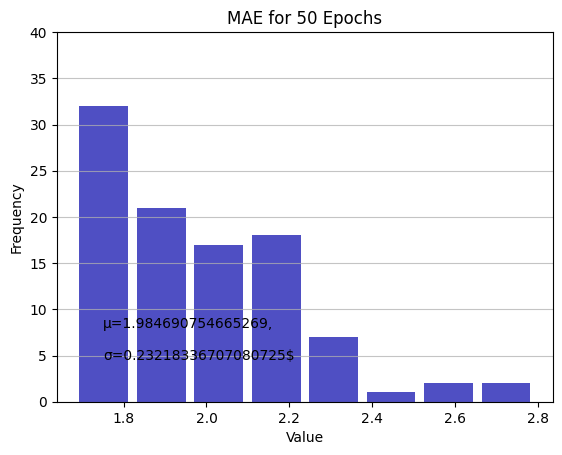

In [12]:
# Mean absolute error, early stop

mean = sum(uni_absolute2) / len(uni_absolute2)
variance = sum([((x - mean) ** 2) for x in uni_absolute2]) / len(uni_absolute2)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=uni_absolute2, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('MAE for 50 Epochs')
maxfreq = m.max()
plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}$'.format(mean,sd))
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

(0.0, 40.0)

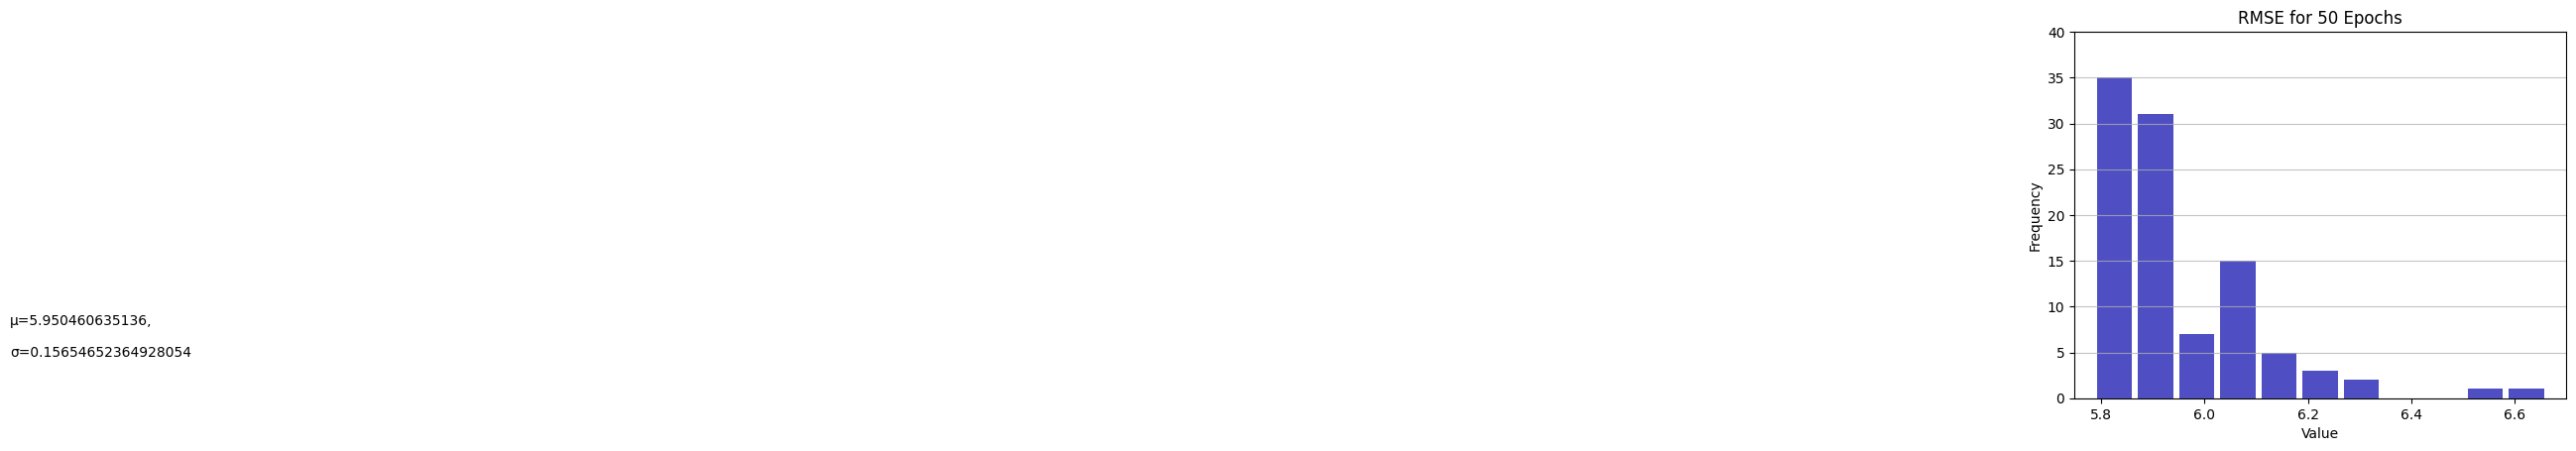

In [13]:
# Root mean squared error, early stop

mean = sum(uni_root2) / len(uni_root2)
variance = sum([((x - mean) ** 2) for x in uni_root2]) / len(uni_root2)
sd = variance ** 0.5

m, bins, patches = plt.hist(x=uni_root2, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('RMSE for 50 Epochs')
plt.text(1.75, 4.5, '\u03BC={},\n\n\u03C3={}'.format(mean,sd))
maxfreq = m.max()
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)